## **Introduction to Image Processing, Computer Vision and Deep Learning**
- Project-1
- 2023/11/06

### Table of Contents：
1. **Image Processing**	 
    - 1.1 Color Separation 
    - 1.2 Color Transformation
    - 1.3 Color Extraction
2. **Image Smoothing**
    - 2.1 Gaussian blur
    - 2.2 Bilateral filter 
    - 2.3 Median filter 
3. **Edge Detection**
    - 3.1 Sobel X 
    - 3.2 Sobel Y 
    - 3.3 Combination and Threshold
    - 3.4 Gradient Angle
4. **Transforms**
    - 4.1 Rotation
    - 4.2 Scaling
    - 4.3 Translate
5. **Training a CIFAR10 Classifier Using VGG19 with BN**
    - 5.1 Load CIFAR10 and Show 9 Augmented Images with labels. 
    - 5.2 Load Model and Show Model Structure
    - 5.3 Show Training/Validating Accuracy and Loss
    - 5.4 Use the Model with Highest Validation Accuracy to Run Inference, Show the Predicted Distribution and Class Label.
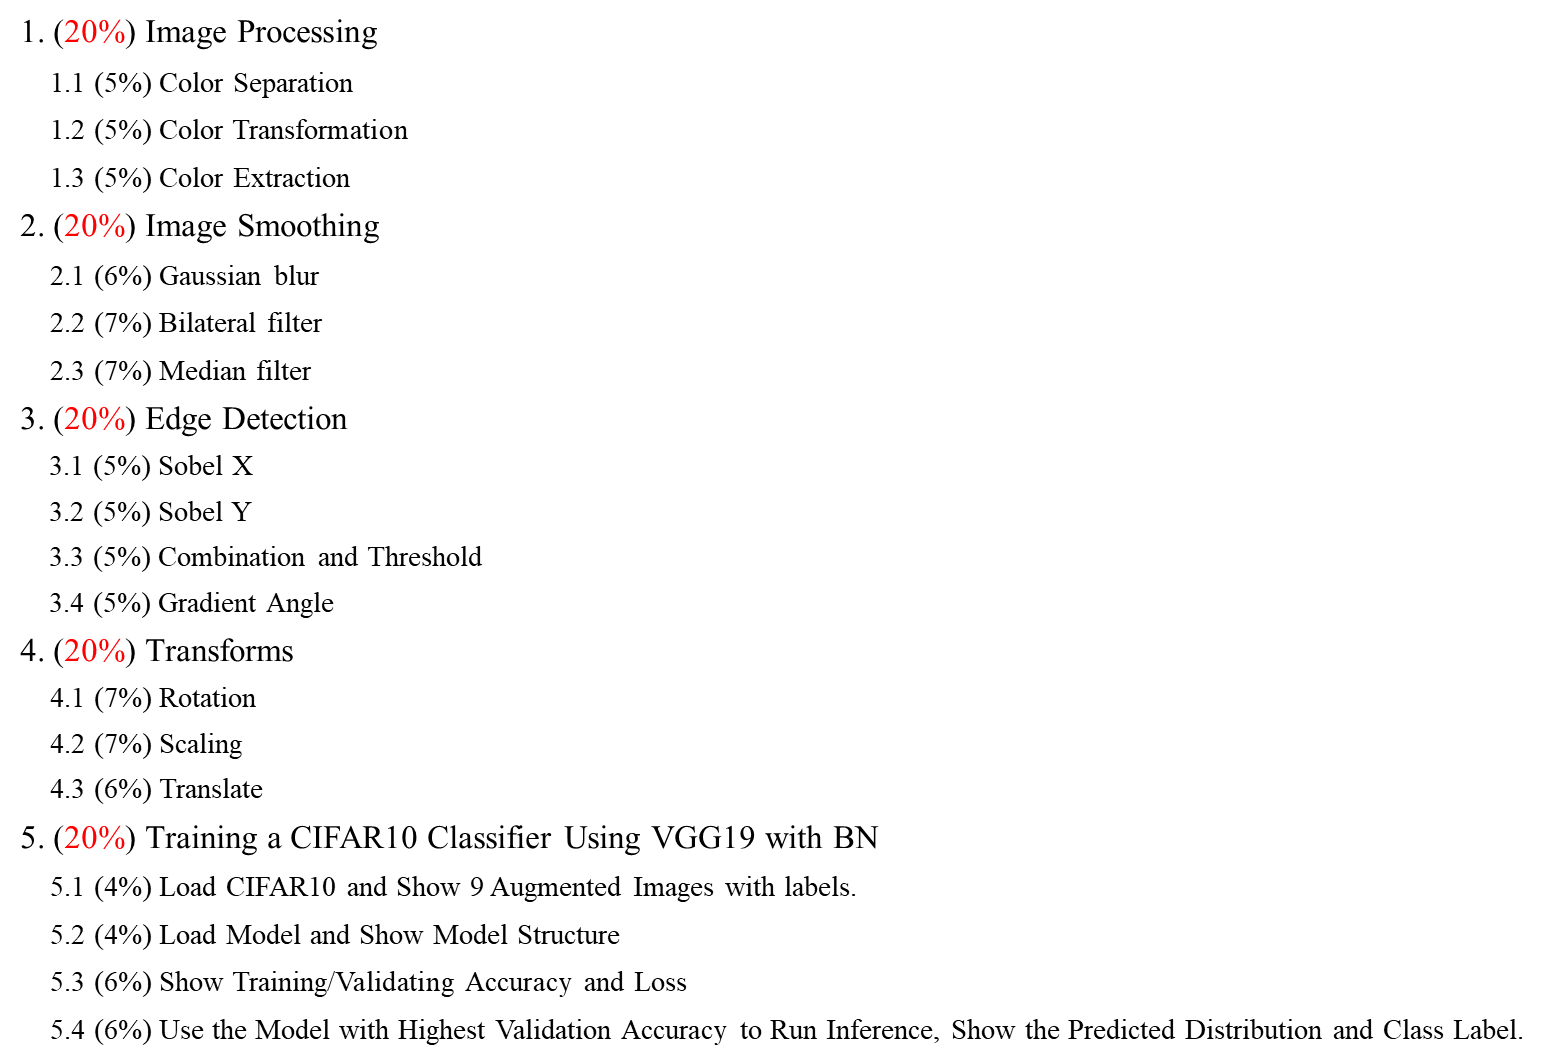
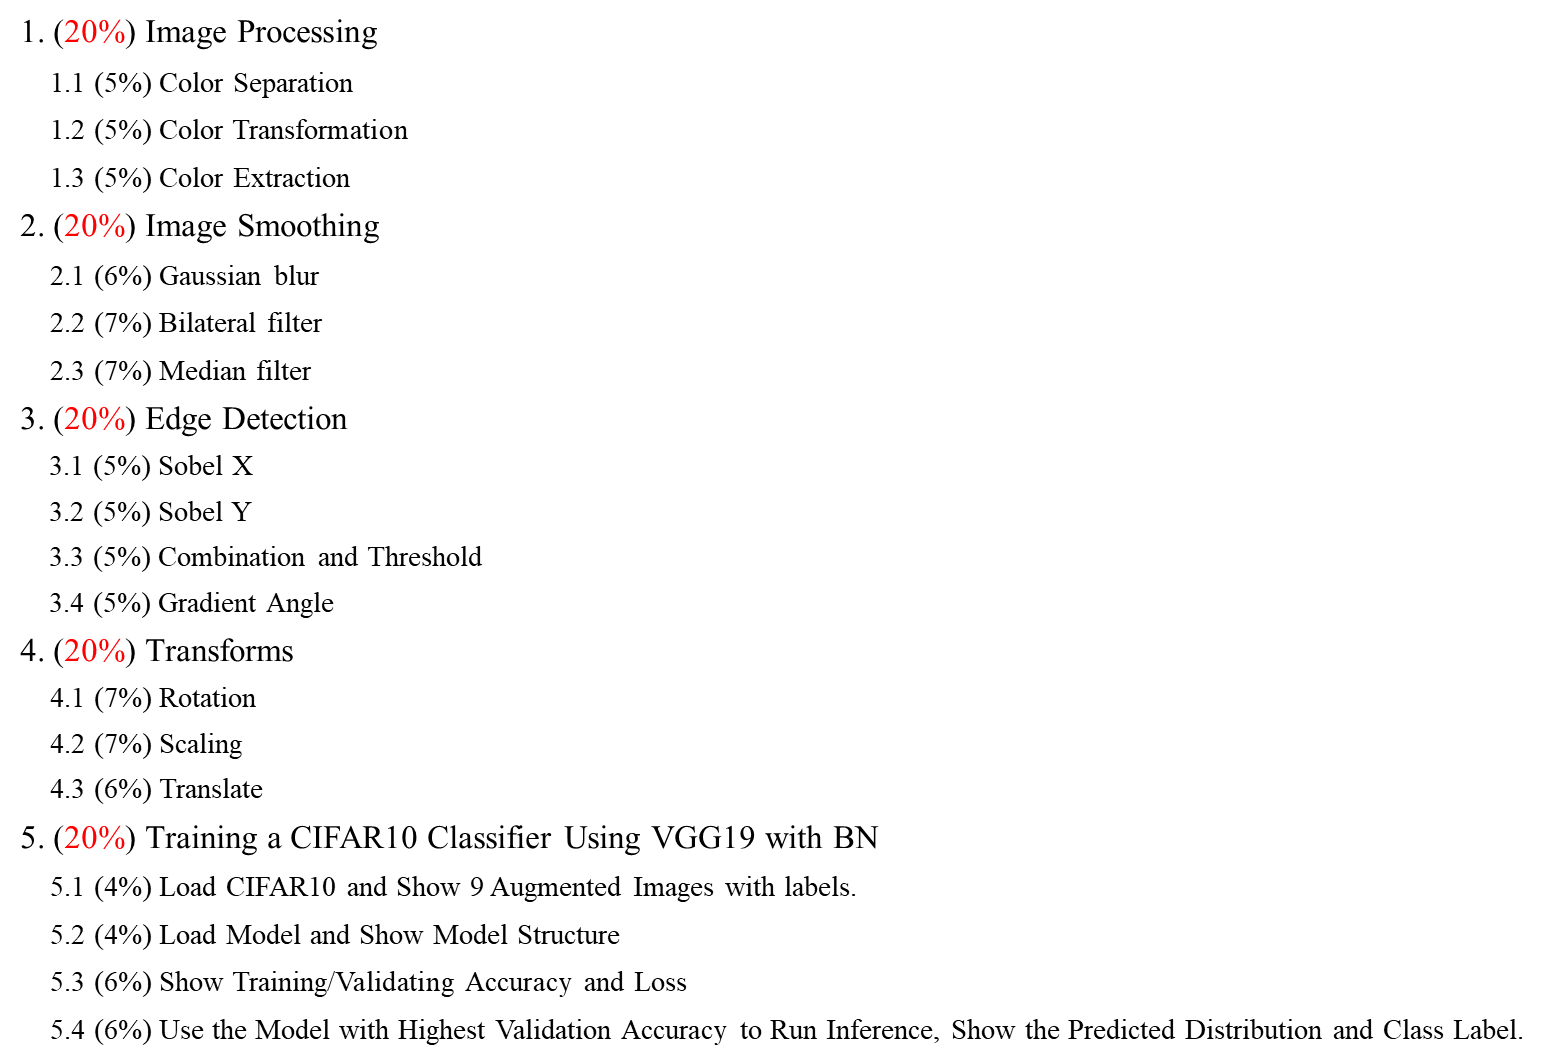
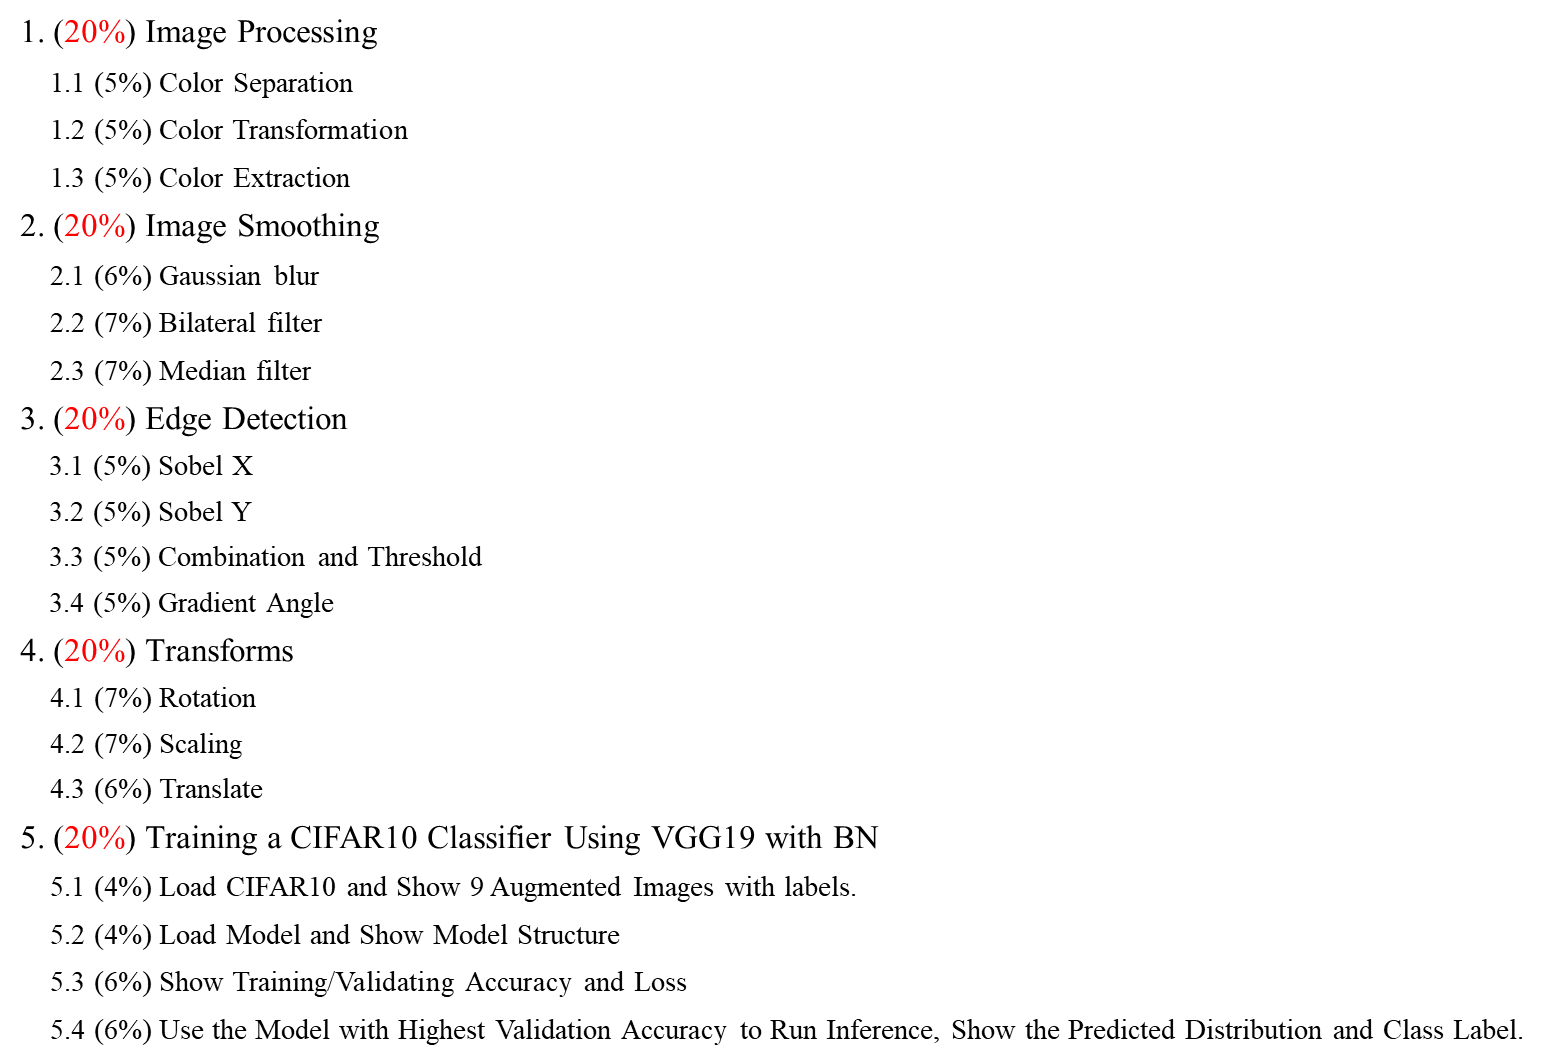
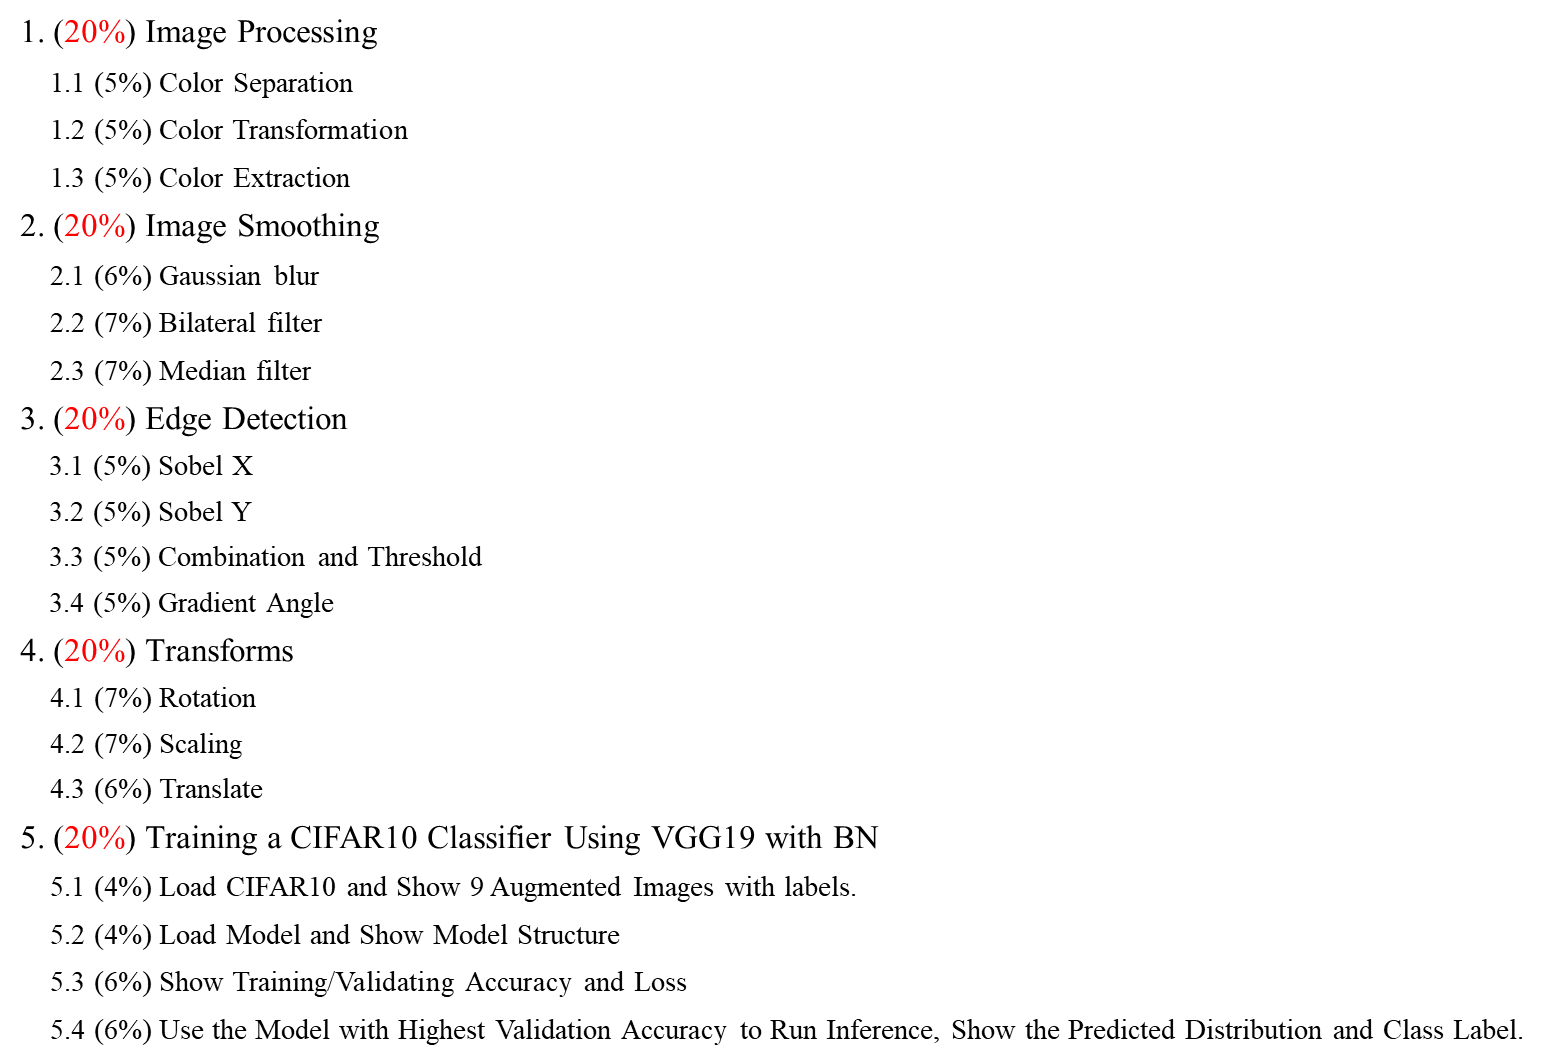
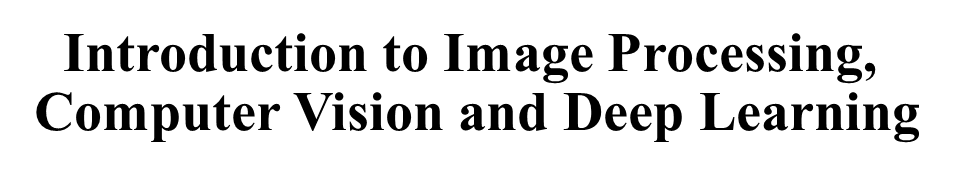
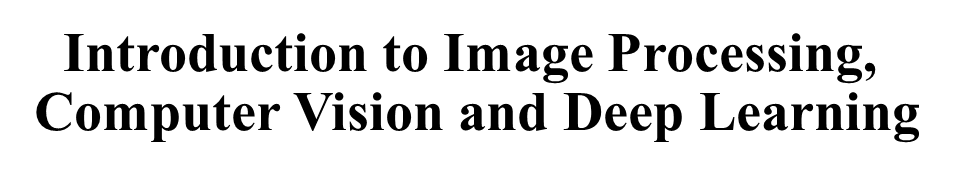
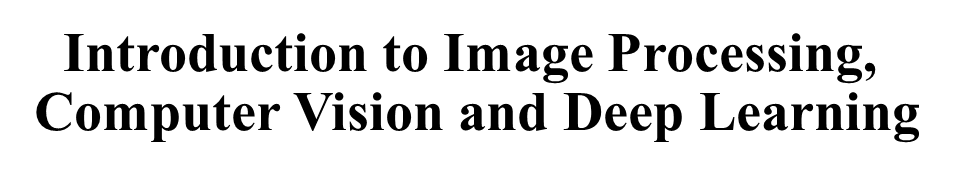
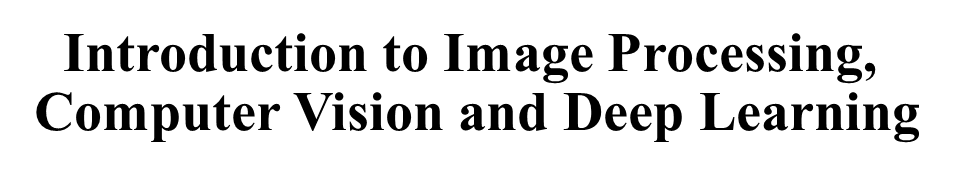

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Nov  2 19:41:47 2023
@author: Mr.Jiang
"""
import cv2
import numpy as np
from numpy import zeros, dot, exp, mgrid, pi, ravel, uint8, square
import matplotlib.pyplot as plt
# from PyQt5.QtWidgets import QApplication, QMainWindow, QLabel, QPushButton, QPlainTextEdit, QFileDialog, QLineEdit
# from PyQt5.QtGui import QIcon
from itertools import product
import math
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.models import vgg19_bn
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from IPython.display import display, Image
from PIL import Image as PILImage
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim


In [2]:
# run on Kaggle
import os

# Kaggle input / working
os.listdir("/kaggle/working/") # reset
print(os.listdir('/kaggle/input/cifar10-python/'))


['cifar-10-python.tar.gz', 'cifar-10-batches-py']


### **cv2.imencode() 和 IPython.display.Image 將圖片嵌入 Notebook 輸出**

- **ret, buffer = cv2.imencode('.jpg', image)**
    - **cv2.imencode() 將圖片壓縮 encode**
    - '.jpg' → 指定格式
    - ret → 轉換是否成功（True 或 False）
    - buffer → 轉換後的二進位數據

- **display(Image(data=buffer.tobytes()))**
    - **buffer.tobytes() 轉換為二進位數據**
    - Image(data=...) 讓 Jupyter Notebook 直接顯示圖片，不需存成檔案


### **RGB（紅、綠、藍）vs. HSV（色相、飽和度、明度）**

- RGB 基於**加法混色**（Additive Color Model），主要用於光學顯示（如電腦螢幕、電視、投影機等）。  
每個顏色都是由紅（Red）、綠（Green）、藍（Blue）三個基色混合而成，不同的組合形成不同的顏色。
    - **範圍**：每個顏色通道通常為 0-255（8-bit），或 0-1（Normalization）
    - **(0, 0, 0)**：黑色（無光）
    - **(255, 255, 255)**：白色（全光）
    - **(255, 0, 0)**：純紅
    - **(0, 255, 0)**：純綠
    - **(0, 0, 255)**：純藍


- HSV 是**基於人眼的色彩感知模型**，將顏色分成三個維度：
    - **H（Hue，色相）**：代表顏色的類型，如紅、藍、黃，取值範圍為 **0° - 360°**
    - **S（Saturation，飽和度）**：表示顏色的純度，範圍 **0-1** 或 **0-100%**；0% 是灰色，100% 最鮮豔
    - **V（Value，明度）**：控制亮度，範圍 **0-1** 或 **0-100%**；0% 是黑色，100% 最亮
    - HSV 更符合人類對顏色的直覺感知

**GB vs. HSV 差異**

| 特色        | RGB | HSV |
|------------|----|----|
| **用途** | 電腦顯示、影像處理 | 影像編輯、顏色篩選、色彩調整 |
| **顏色表示** | 透過 R/G/B 三色混合 | 透過色相（H）+飽和度（S）+亮度（V）描述 |
| **亮度控制** | 需要同時調整 R、G、B | 直接調整 V（明度） |
| **飽和度控制** | 需要對 R、G、B 做數學計算 | 直接調整 S（飽和度） |
| **顏色調整直覺性** | 不直觀，需調整三個通道 | 直觀，只需調整 H 來改變顏色 |
| **轉換計算** | 直接在 3D 色彩空間運算 | 需要極坐標轉換（較複雜） |


- **適合使用 RGB 的情境**
    - **電腦顯示技術**：因為螢幕是透過 R、G、B 三色混合來呈現顏色。
    - **機器學習與深度學習**：圖像資料通常以 RGB 儲存，許多神經網路使用 RGB 格式作為輸入。
    - **低階影像處理**：例如直接操作像素值（如 OpenCV 讀取影像時通常使用 BGR 格式）。

- **適合使用 HSV 的情境**
    - **影像處理與編輯**：HSV 允許獨立調整顏色（H）、飽和度（S）和亮度（V），更容易進行色彩篩選或變更。
    - **顏色篩選**：HSV 色彩模型對於區分不同顏色更加有效，如 OpenCV 影像處理中的顏色偵測常用 HSV。
    - **顏色校正**：可獨立控制亮度（V）而不影響顏色（H），這在調整照片曝光度時非常有用。


1.1 Buttom clicked
b.shape: (452, 640)
g.shape: (452, 640)
r.shape: (452, 640)

Displayed: Origin, RGB.jpg


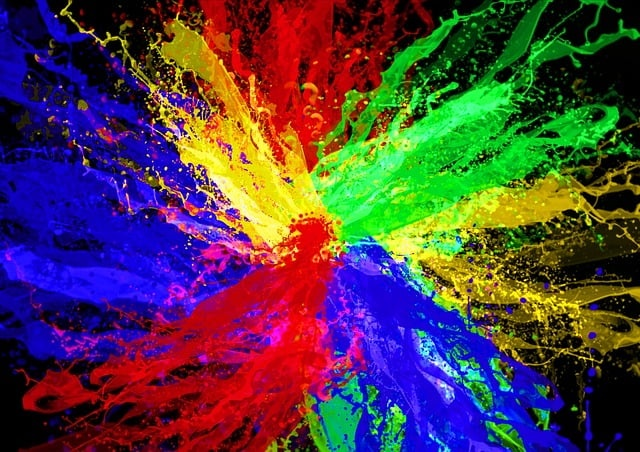


Displayed: B_channel


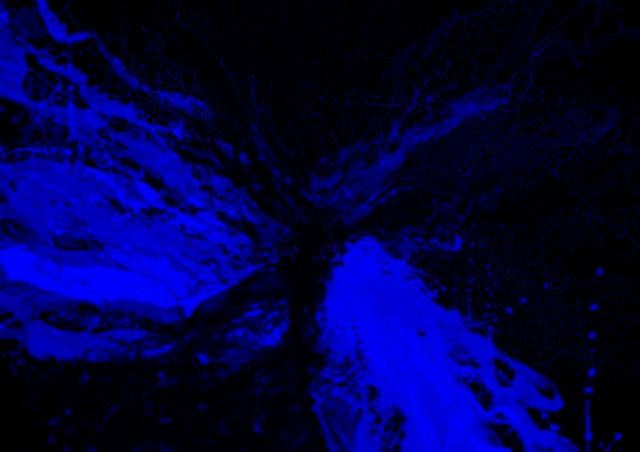


Displayed: G_channel


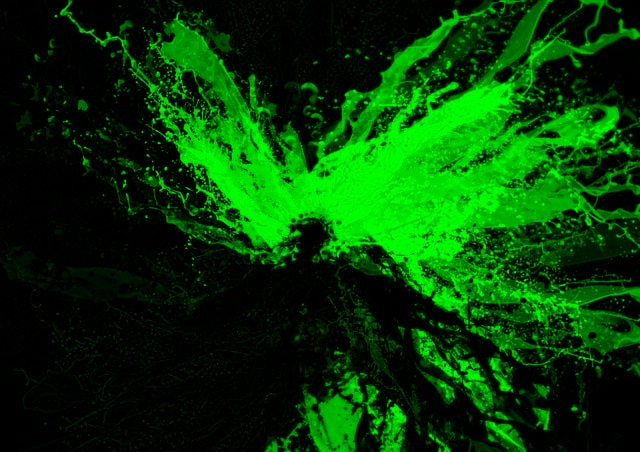


Displayed: R_channel


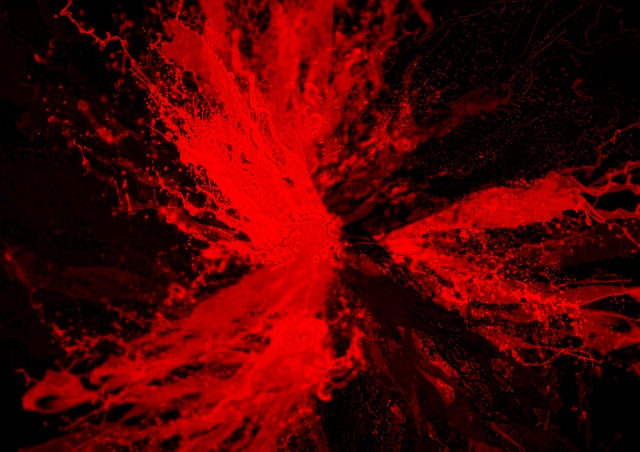

In [72]:
# 1.1 Color Separation---------------------------------------------------

class Q11():
    def Color_Separation(self):
        print("1.1 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q1_image/rgb.jpg")

        # cv2.split(image) get B, G, R
        if image is not None:
            b, g, r = cv2.split(image)

            # (452, 640)
            print(f"b.shape: {b.shape}\n" +
                  f"g.shape: {g.shape}\n" +
                  f"r.shape: {r.shape}")
            
            # cv2.merge(b,g,r)
            # np.zeros_like() 填充不需要的 channel
            rgb_b = cv2.merge([b, np.zeros_like(g), np.zeros_like(r)])
            rgb_g = cv2.merge([np.zeros_like(b), g, np.zeros_like(r)])
            rgb_r = cv2.merge([np.zeros_like(b), np.zeros_like(g), r])

            # display R, G, B channel
            cv2.imwrite("RGB.jpg", image)
            print("\nDisplayed: Origin, RGB.jpg")
            display(Image(filename="RGB.jpg"))
        
            cv2.imwrite("RGB_b.jpg", rgb_b)
            print("\nDisplayed: B_channel")
            display(Image(filename="RGB_b.jpg"))

            cv2.imwrite("RGB_g.jpg", rgb_g)
            print("\nDisplayed: G_channel")
            display(Image(filename="RGB_g.jpg"))

            cv2.imwrite("RGB_r.jpg", rgb_r)
            print("\nDisplayed: R_channel")
            display(Image(filename="RGB_r.jpg"))
            
        else:
            print("請先選擇圖片")

q11 = Q11()
q11.Color_Separation()


1.2 Buttom clicked

Displayed: I1, Standard Gray


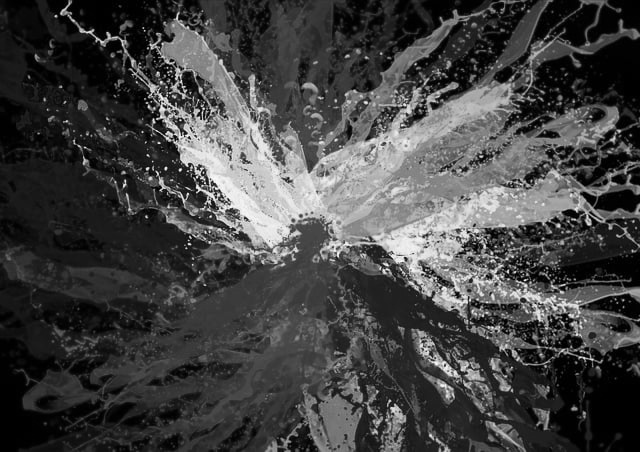


Displayed: I2, Weighted Gray


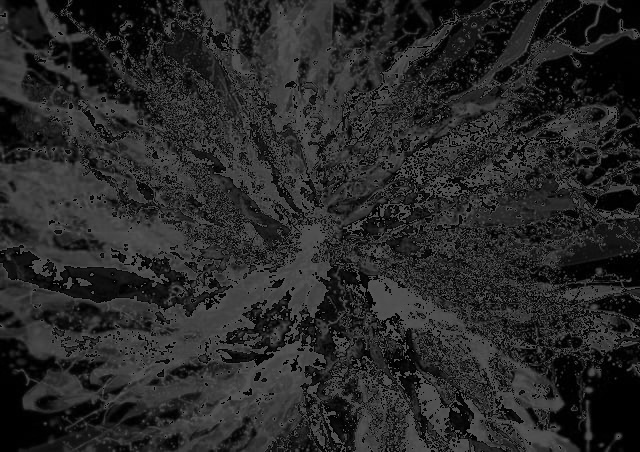

In [23]:
# 1.2 Color Transformation-----------------------------------------------

class Q12():
    def Color_Transformation(self):
        print("1.2 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q1_image/rgb.jpg")
        if image is not None:
            b, g, r = cv2.split(image)

            # "rgb.jpg" convert to gray -> I1
            # Standard Gray = 0.299 * R + 0.587 * G + 0.114 * B
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            i2 = r + g + b

            # set channel weight
            weight = 1/3.0 # float

            weighted_gray_image = np.zeros_like(i2, dtype=np.float32) # set shape
            weighted_gray_image = i2 * weight

            # float32 -> uint8 for image display or store
            weighted_gray_image = weighted_gray_image.astype(np.uint8) # np.uint8（0-255）

            # display
            cv2.imwrite("Gray_image.jpg", gray_image)
            print("\nDisplayed: I1, Standard Gray")
            display(Image(filename="Gray_image.jpg"))
            
            cv2.imwrite("Weighted_gray_image.jpg", weighted_gray_image)
            print("\nDisplayed: I2, Weighted Gray")
            display(Image(filename="Weighted_gray_image.jpg"))

        else:
            print("請先選擇圖片")

q12 = Q12()
q12.Color_Transformation()


1.3 Buttom clicked

Displayed: I1


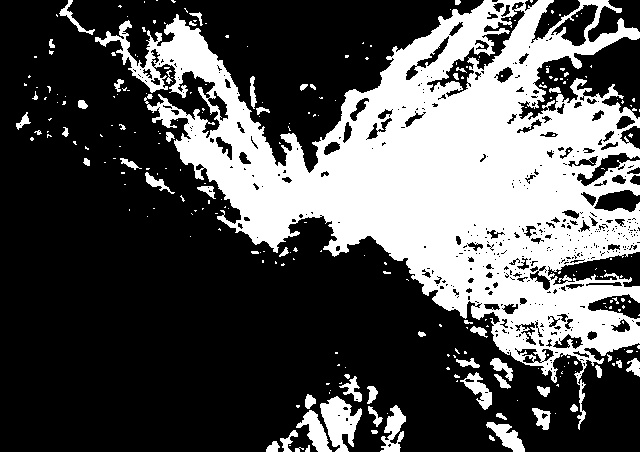


Displayed: I2


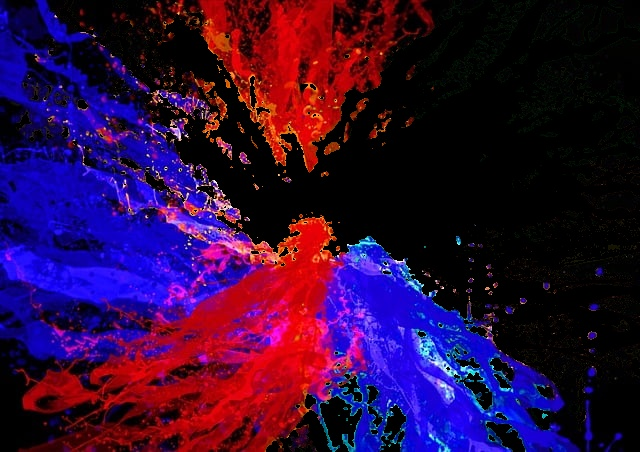

In [24]:
# 1.3 Color Extraction---------------------------------------------------

class Q13():
    def Color_Extraction(self):
        print("1.3 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q1_image/rgb.jpg")
        
        if image is not None:
            # convert RGB to HSV（Hue, Saturation, Value）
            hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            # define 黃綠色區域的下限和上限
            '''
            Hue = 16~85 → 涵蓋黃綠色
            Saturation = 27~255 → 避免過於灰色或不飽和的區域被選到。
            Value = 25~255 → 允許不同亮度的顏色。
            '''
            lower_bound = np.array([16, 27, 25])
            upper_bound = np.array([85, 255, 255])

            # cv2.inRange() 產生遮罩，將範圍內的黃綠色設為白色（255），其他顏色為黑色（0）
            i1 = cv2.inRange(hsv_img, lower_bound, upper_bound)

            # inverse mask -> 黃綠色設為黑色（0），其他顏色為白色（255）
            yellow_green_mask = cv2.bitwise_not(i1)

            # inverse mask apply to image
            i2 = cv2.bitwise_and(image, image, mask=yellow_green_mask)

            # display
            cv2.imwrite("I1.jpg", i1)
            print("\nDisplayed: I1")
            display(Image(filename="I1.jpg"))
            
            cv2.imwrite("I2.jpg", i2)
            print("\nDisplayed: I2")
            display(Image(filename="I2.jpg"))


        else:
            print("請先選擇圖片")

q13 = Q13()
q13.Color_Extraction()


### **Gaussian Blur vs. Bilateral Filter vs. Median Filter**


| **Filter**           | **主要作用**                                      | **適用場景** |
|--------------------|--------------------------------|--------------|
| **Gaussian Blur**   | 平滑影像，減少高頻雜訊（去除細節）              | 一般模糊處理、降噪、邊緣檢測前的預處理 |
| **Bilateral Filter** | 平滑影像的同時保留邊緣細節                      | 影像去雜訊但不希望模糊邊緣，例如人臉美化 |
| **Median Filter**   | 透過中值運算去除椒鹽雜訊（Salt & Pepper Noise） | 處理含椒鹽雜訊的影像，如掃描文件修復 |


1. **(1) Gaussian Blur**
- 使用高斯函數對影像進行平滑處理，使像素值根據周圍像素的加權平均來更新，並且權重遵循**高斯分佈（Gaussian Distribution)**。

    - 能夠平滑影像，去除高頻雜訊
    - **會模糊邊緣，影像細節可能喪失**
    - 適用於**影像降噪**、**邊緣檢測前處理**

- 適用：
    - 邊緣檢測前的預處理（如：Canny Edge Detection）
    - 影像縮小時的平滑處理
    - 處理低雜訊影像的模糊效果

2. **(2) Bilateral Filter（雙邊濾波）**
- 雙邊濾波不僅考慮空間鄰近性，還考慮像素的**色彩相似度**，透過這種方式，可以**平滑影像的同時保留邊緣細節**。

    - **可平滑影像並保留邊緣**
    - **比 Gaussian Blur 更複雜，計算成本較高**
    - **適合人臉美化、噪點去除，但保留紋理**

- 適用：
    - **人臉修飾**（去除細小雜訊，但保留輪廓）
    - **保留邊緣的降噪**（如 MRI 醫學影像）
    - **動畫影像降噪**（讓畫面更乾淨但不模糊輪廓）

3. **(3) Median Filter（中值濾波）**
 - 中值濾波主要用於去除 **椒鹽雜訊（Salt & Pepper Noise）**，即影像中出現的隨機黑點或白點，它不是透過平均像素值，而是取周圍像素的**中值**來替換當前像素。

    - **專門用於消除椒鹽雜訊**
    - **不會模糊邊緣**
    - **對於高斯雜訊（Gaussian Noise）效果較差**

- 計算方式：
    1. 取出一個 **k × k** 區域內的所有像素值
    2. 對這些像素排序
    3. 取**中位數**來替換當前像素值

- 適用：
    - **掃描文件修復**
    - **老舊照片降噪**
    - **醫學影像處理（如 CT 掃描去雜訊）**


| **特性**            | **Gaussian Blur** | **Bilateral Filter** | **Median Filter** |
|------------------|-----------------|------------------|----------------|
| **降噪能力**      |  **⭐⭐⭐**        | **⭐⭐⭐⭐**             | **⭐⭐⭐⭐**（對椒鹽雜訊效果最佳） |
| **邊緣保留能力**  | **❌**（模糊邊緣）  | **✔️**（能保留邊緣） | **✔️**（不模糊邊緣） |
| **適用雜訊類型**  | **高斯雜訊**    | **一般影像雜訊** | **椒鹽雜訊** |
| **計算成本**      | **⭐⭐**（較快）     | **⭐⭐⭐⭐**（較慢）    | **⭐⭐⭐** （適中） |
| **應用場景**      | 邊緣檢測前處理 | 影像降噪但保留細節 | 影像含椒鹽雜訊 |


2.1 Button clicked

Displayed: Gaussian Blur with kernel size (3, 3)


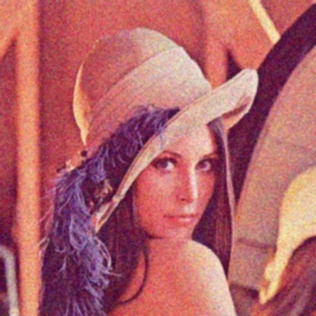


Displayed: Gaussian Blur with kernel size (5, 5)


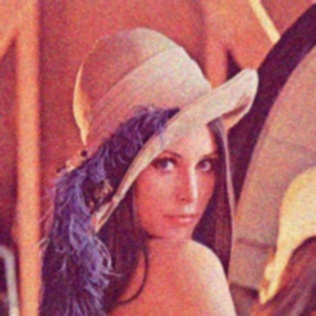


Displayed: Gaussian Blur with kernel size (7, 7)


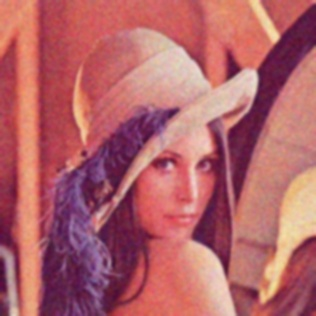


Displayed: Gaussian Blur with kernel size (9, 9)


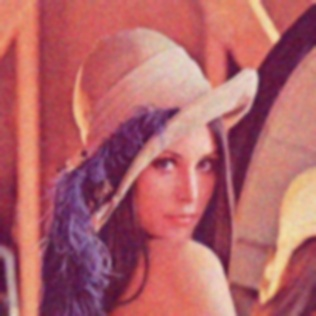


Displayed: Gaussian Blur with kernel size (11, 11)


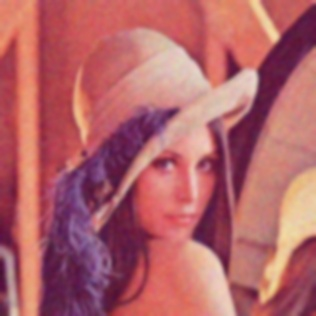

In [29]:
# 2.1 Gaussian Blur------------------------------------------------------

class Q21():
    def Gaussian_Blur(self):
        print("2.1 Button clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q2_image/image1.jpg")
        if image is not None:
            
            # define multiple core sizes (kernel_size = 2 * m + 1)
            kernel_sizes = [(3, 3), (5, 5), (7, 7), (9, 9), (11, 11)]  # 對應 m = 1, 2, 3, 4, 5
            for i, kernel_size in enumerate(kernel_sizes, 1): # i begin with 1 -> (1,(3,3))
                
                # apply to Gaussian Blur
                blurred_image = cv2.GaussianBlur(image, kernel_size, sigmaX=0, sigmaY=0) # sigmaX、sigmaY 為高斯標準差，0 代表讓 OpenCV 自動計算最合適的標準差
                
                # display
                ret, buffer = cv2.imencode('.jpg', blurred_image)
                print(f"\nDisplayed: Gaussian Blur with kernel size {kernel_size}")
                display(Image(data=buffer.tobytes()))

        else:
            print("請先選擇圖片")

q21 = Q21()
q21.Gaussian_Blur()


2.2 Buttom clicked

Displayed: Bilateral Filter with kernel size 3


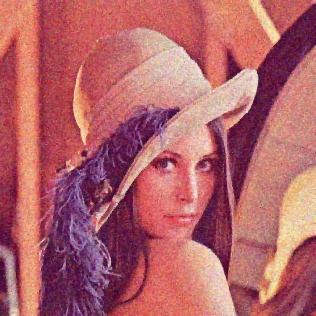


Displayed: Bilateral Filter with kernel size 5


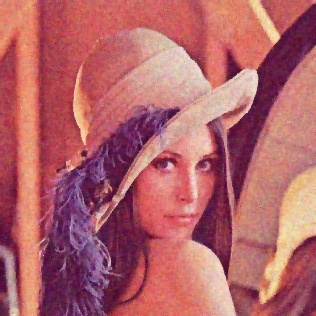


Displayed: Bilateral Filter with kernel size 7


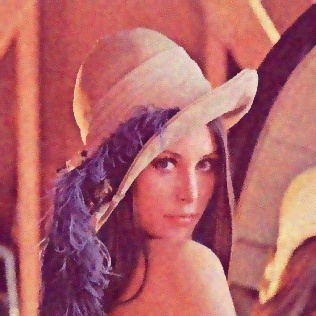


Displayed: Bilateral Filter with kernel size 9


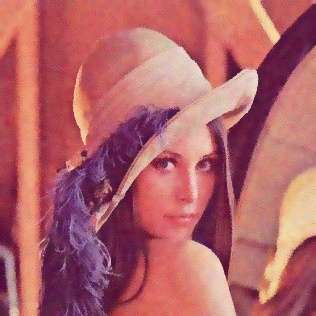


Displayed: Bilateral Filter with kernel size 11


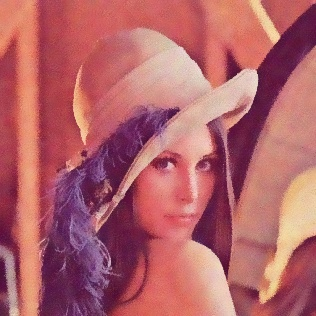

In [31]:
# 2.2 Bilateral Filter---------------------------------------------------

class Q22():
    def Bilateral_Filter(self):
        print("2.2 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q2_image/image1.jpg")
        if image is not None:
            
            # define multiple core sizes (kernel_size = 2 * m + 1)
            kernel_sizes = [3, 5, 7, 9, 11]  # 對應 m = 1, 2, 3, 4, 5
            for i, kernel_size in enumerate(kernel_sizes, 1): # i begin with 1 -> (1,3)
                
                # apply to Bilateral Filter
                filtered_image = cv2.bilateralFilter(image, kernel_size, sigmaColor=90, sigmaSpace=90)
                
                # display
                ret, buffer = cv2.imencode('.jpg', filtered_image)
                print(f"\nDisplayed: Bilateral Filter with kernel size {kernel_size}")
                display(Image(data=buffer.tobytes()))

        else:
            print("請先選擇圖片")

q22 = Q22()
q22.Bilateral_Filter()


2.3 Buttom clicked

Displayed: Median Filter with kernel size 3


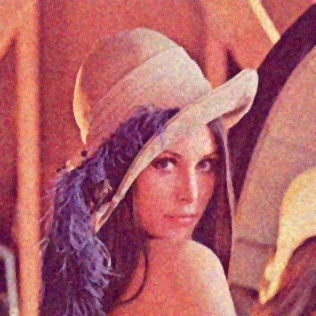


Displayed: Median Filter with kernel size 5


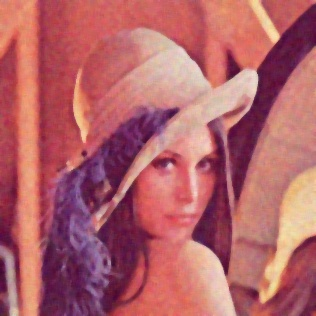


Displayed: Median Filter with kernel size 7


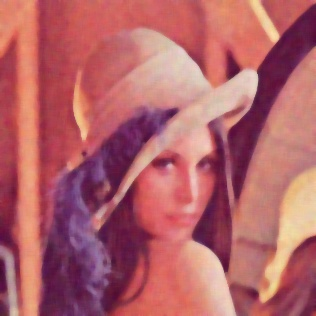


Displayed: Median Filter with kernel size 9


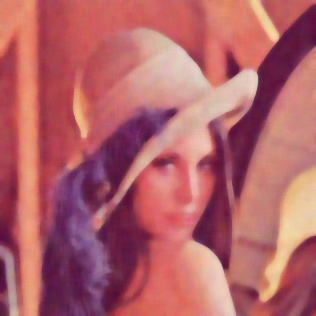


Displayed: Median Filter with kernel size 11


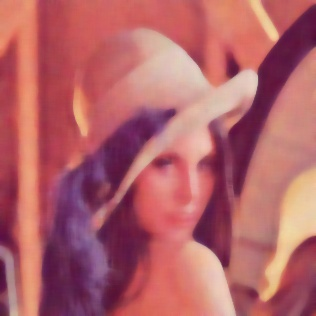

In [32]:
# 2.3 Median Filter------------------------------------------------------

class Q23():
    def Median_Filter(self):
        print("2.3 Buttom clicked")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q2_image/image1.jpg")
        if image is not None:
            
            # define multiple core sizes (kernel_size = 2 * m + 1)
            kernel_sizes = [3, 5, 7, 9, 11]  # 對應 m = 1, 2, 3, 4, 5
            for i, kernel_size in enumerate(kernel_sizes, 1): # i begin with 1 -> (1,3)
                
                # apply to Median Filter
                filtered_image = cv2.medianBlur(image, kernel_size)
                
                # display
                ret, buffer = cv2.imencode('.jpg', filtered_image)
                print(f"\nDisplayed: Median Filter with kernel size {kernel_size}")
                display(Image(data=buffer.tobytes()))

        else:
            print("請先選擇圖片")

q23 = Q23()
q23.Median_Filter()


### **Sobel 邊緣檢測 (Sobel Edge Detection)**
- **Sobel 運算子（Sobel Operator）** 是一種 Edge Detection 技術，運算的主要目的是計算影像的梯度，也就是**像素亮度變化的速率**，用於強調影像中的邊緣特徵，特別是梯度變化較大的區域，如：物體邊界，是一個一階微分的 filter，主要計算影像在 **x 軸與 y 軸方向的梯度變化**，進而找出邊緣。

- Sobel 運算子屬於**微分運算子（Derivative Operator）**，其原理是使用卷積運算（Convolution）來計算影像的梯度。
- 透過兩個 **3×3 的卷積核（Kernel）** 來分別計算影像在水平方向與垂直方向的梯度：

1. **水平方向（X 軸）梯度卷積核**用於偵測**垂直邊緣**（Vertical Edges）。
\
\begin{bmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{bmatrix}



2. **垂直方向（Y 軸）梯度卷積核**用於偵測**水平邊緣**（Horizontal Edges）。
\
\begin{bmatrix}
-1 & -2 & -1 \\
0  &  0 &  0 \\
1  &  2 &  1
\end{bmatrix}

- **優點**：
    - 能夠同時檢測 **水平方向** 和 **垂直方向** 的邊緣。
    - 相較於單純的微分運算（如 Roberts 運算子），Sobel 具有**平滑效果**，能夠減少噪聲影響。
    - 計算量低，適合即時處理（如影像偵測應用）。

- **缺點**：
    - 只能偵測 **一階梯度變化**，無法準確找到較微弱的邊緣。
    - 對於含有較多雜訊的影像，檢測效果不佳，需要搭配**高斯模糊（Gaussian Blur）**來去雜訊。

- **主要用於**：
    - **影像邊緣檢測**
    - **物件輪廓強化**
    - **影像特徵提取**（如：手寫字辨識）
    - **工業檢測**（如：瑕疵檢測）


3.1 Buttom clicked, wait a minute

Displayed: Origin


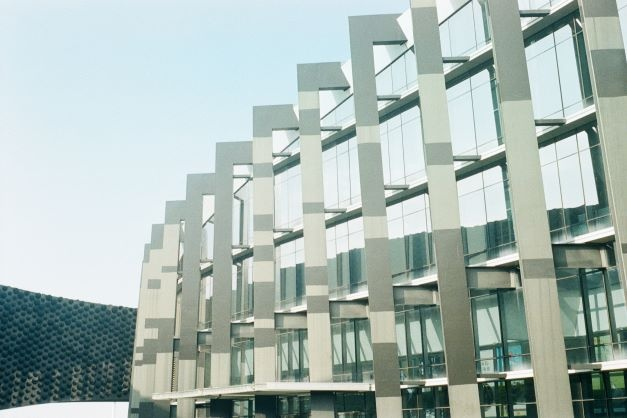


Displayed: Sobel x


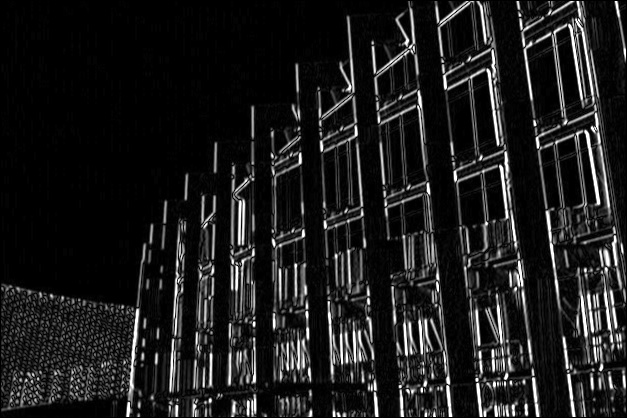

In [6]:
# 3.1 Sobel x -----------------------------------------------------------

class Q31():
    def Sobel_X(self): # 邊緣就是影像中，像素值突然改變的地方
        print("3.1 Buttom clicked, wait a minute")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q3_image/building.jpg")
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

            # sobel_X
            container = np.copy(blurred_image) # container = np.copy() set copy，避免直接操作原圖片
            size = container.shape
            row = size[0]
            col = size[1]

            # 從左上角到右下角的順序進行
            sobel = np.zeros((row, col), dtype = np.int16) # 儲存 Sobel 運算結果
            for i in range(row):
                for j in range(col): # row - 1 跟 col - 1 分別為最底下那列跟最右邊那行
                    if i == 0 or i == row - 1 or j == 0 or j == col - 1:
                        sobel[i][j] = 0 # 這些像素由於缺乏完整的相鄰像素，因此在進行卷積運算時，需要特別處理；梯度為 0，代表邊緣的「變化率」是 0
                    else:
                        # 使用 3x3 Sobel 核心矩陣 ([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]) 對當前像素及其周圍像素進行加權求和
                        sobel[i][j] = (-2.0) * container[i][j - 1] + 0.0 * container[i][j] + 2.0 * container[i][j + 1] + (-1.0) * container[i - 1][j - 1] + 0.0 * container[i - 1][j] + 1.0 * container[i - 1][j + 1] + (-1.0) * container[i + 1][j - 1] + 0.0 * container[i + 1][j] + 1.0 * container[i + 1][j + 1]

            # 將運算結果取絕對值，並 dtype -> uint8
            sobel = cv2.convertScaleAbs(sobel)

            # display
            ret, buffer = cv2.imencode('.jpg', image)
            print("\nDisplayed: Origin")
            display(Image(data=buffer.tobytes()))
            
            ret, buffer = cv2.imencode('.jpg', sobel)
            print(f"\nDisplayed: Sobel x")
            display(Image(data=buffer.tobytes()))
        
        else:
            print("請先選擇圖片")

q31 = Q31()
q31.Sobel_X()


3.2 Buttom clicked, wait a minute

Displayed: Origin


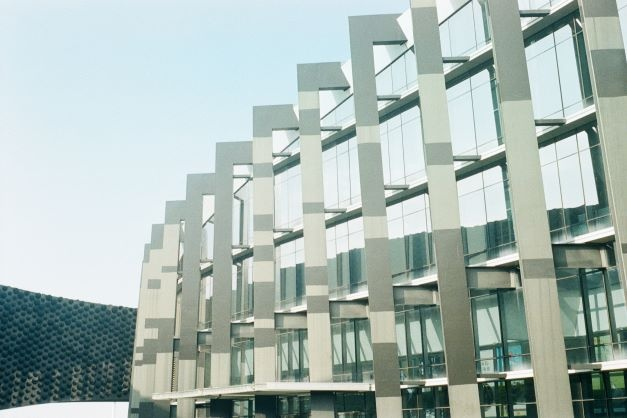


Displayed: Sobel y


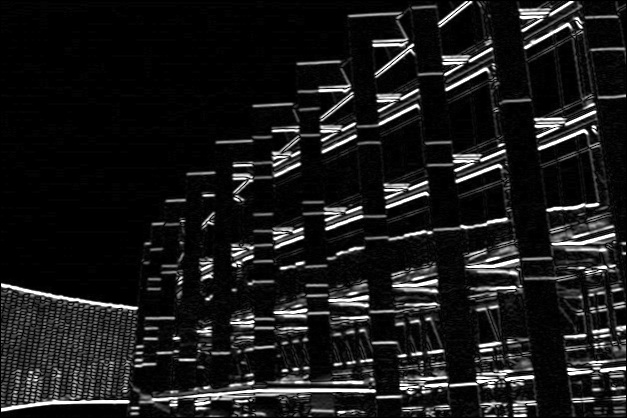

In [4]:
# 3.2 Sobel y -----------------------------------------------------------

class Q32():
    def Sobel_Y(self):
        print("3.2 Buttom clicked, wait a minute")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q3_image/building.jpg")
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

            # sobel_Y
            container = np.copy(blurred_image) # container size = blurred_image
            size = container.shape
            row = size[0]
            col = size[1]

            # for storing operation result
            sobel = np.zeros((row, col), dtype = np.int16)

            for i in range(row):
                for j in range(col):
                    if i == 0 or i == row - 1 or j == 0 or j == col - 1:
                        sobel[i][j] = 0  # 同樣在圖片四周都將 weight = 0
                    else:
                        # 非四周做運算 ([-1, -2, -1], [0, 0, 0], [1, 2, 1])
                        sobel[i][j] = (2.0) * container[i + 1][j] + 0.0 * container[i][j] + (-2.0) * container[i - 1][j] + (1.0) * container[i + 1][j - 1] + 0.0 * container[i][j - 1] + (-1.0) * container[i - 1][j - 1] + (1.0) * container[i + 1][j + 1] + 0.0 * container[i][j + 1] + (-1.0) * container[i - 1][j + 1]

            # 將運算結果取絕對值，並 dtype -> uint8
            sobel = cv2.convertScaleAbs(sobel)
            
            # display
            ret, buffer = cv2.imencode('.jpg', image)
            print("\nDisplayed: Origin")
            display(Image(data=buffer.tobytes()))
            
            ret, buffer = cv2.imencode('.jpg', sobel)
            print(f"\nDisplayed: Sobel y")
            display(Image(data=buffer.tobytes()))
            
        else:
            print("請先選擇圖片")

q32 = Q32()
q32.Sobel_Y()


3.3 Buttom clicked, wait a minute

Displayed: Combination


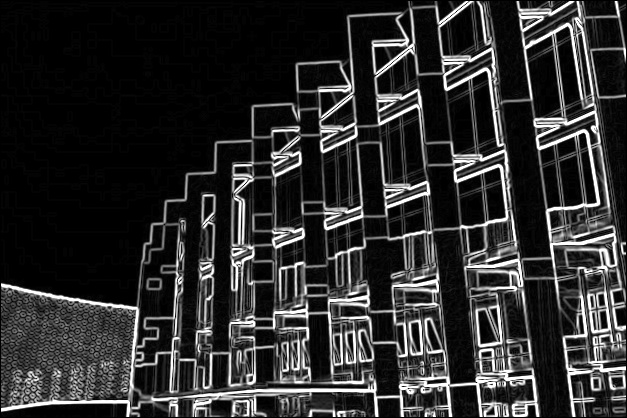


Displayed: Threshold Result


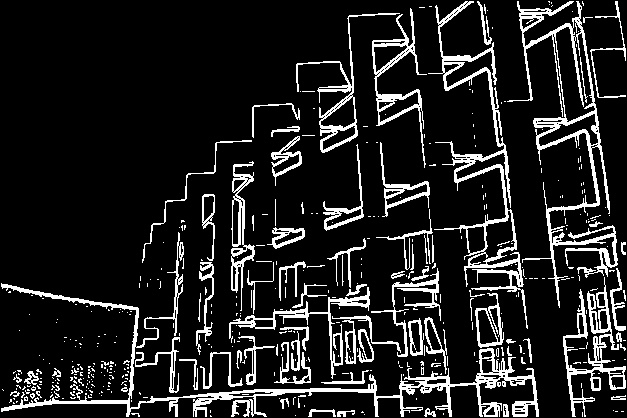

In [29]:
# 3.3 Combination and Threshold------------------------------------------

class Q33():
    def Combination_and_Threshold(self):
        print("3.3 Buttom clicked, wait a minute")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q3_image/building.jpg")
        if image is not None:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)
            
            container1 = np.copy(blurred_image) # for sobel X
            container2 = np.copy(blurred_image) # for sobel Y
            size = container1.shape
            row = size[0]
            col = size[1]

            # for storing operation result
            sobel_x = np.zeros((row, col), dtype = np.int16)
            sobel_y = np.zeros((row, col), dtype = np.int16)
            combine_xy = np.zeros((row, col), dtype = np.uint16)
            
            for i in range(row):
                for j in range(col):
                    if i == 0 or i == row - 1 or j == 0 or j == col - 1:
                        sobel_x[i][j] = 0 
                    else:
                        # ([-1, 0, 1], [-2, 0, 2], [-1, 0, 1])
                        sobel_x[i][j] = (-2.0) * container1[i][j - 1] + 0.0 * container1[i][j] + 2.0 * container1[i][j + 1] + (-1.0) * container1[i - 1][j - 1] + 0.0 * container1[i - 1][j] + 1.0 * container1[i - 1][j + 1] + (-1.0) * container1[i + 1][j - 1] + 0.0 * container1[i + 1][j] + 1.0 * container1[i + 1][j + 1]

            
            for i in range(row):
                for j in range(col):
                    if i == 0 or i == row - 1 or j == 0 or j == col - 1:
                        sobel_y[i][j] = 0
                    else:
                        # ([-1, -2, -1], [0, 0, 0], [1, 2, 1])
                        sobel_y[i][j] = (2.0) * container2[i + 1][j] + 0.0 * container2[i][j] + (-2.0) * container2[i - 1][j] + (1.0) * container2[i + 1][j - 1] + 0.0 * container2[i][j - 1] + (-1.0) * container2[i - 1][j - 1] + (1.0) * container2[i + 1][j + 1] + 0.0 * container2[i][j + 1] + (-1.0) * container2[i - 1][j + 1]
            
            sobelx = sobel_x
            sobely = sobel_y

            # == cv2.magnitude()
            for i in range(row):
                for j in range(col):
                    combine_xy[i][j] = min(255, np.sqrt(sobelx[i][j] ** 2 + sobely[i][j] ** 2)) # Normalize combination 

            # combine_xy result
            combined_image = cv2.convertScaleAbs(combine_xy)
            
            # threshold_result
            threshold = 128
            threshold_result = np.zeros_like(combined_image)
            threshold_result[combined_image < threshold] = 0
            threshold_result[combined_image >= threshold] = 255

            # display
            ret, buffer = cv2.imencode('.jpg', combined_image)
            print("\nDisplayed: Combination")
            display(Image(data=buffer.tobytes()))
            
            ret, buffer = cv2.imencode('.jpg', threshold_result)
            print("\nDisplayed: Threshold Result")
            display(Image(data=buffer.tobytes()))
            
        else:
            self.labelL1.setText("請先選擇圖片")

q33 = Q33()
q33.Combination_and_Threshold()


3.4 Buttom clicked, wait a minute
Gradient Angle Min: 0.0, Max: 359.8258492307934

Displayed: Angle Range 120~180


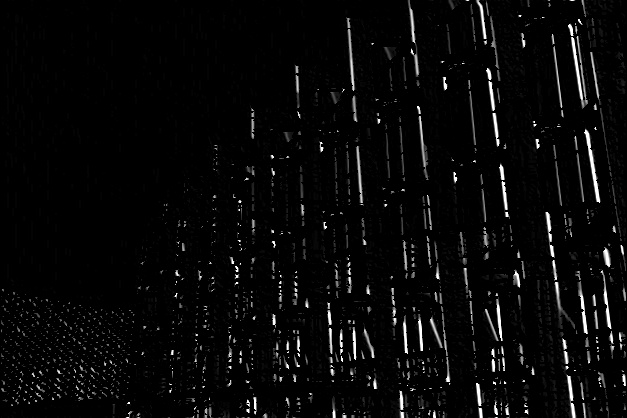


Displayed: Angle Range 210~330


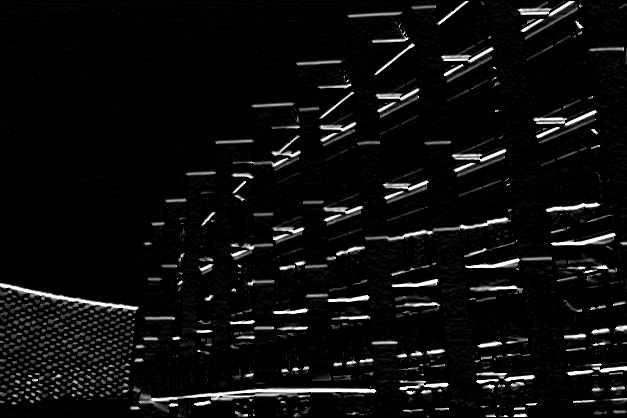

In [30]:
# 3.4 Gradient Angle ----------------------------------------------------

class Q34():
    def Gradient_Angle(self):
        print("3.4 Buttom clicked, wait a minute")
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q3_image/building.jpg")
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)
        
        # cv.Sobel() 支援 CV_64F float 避免數值溢位，保留負數，以確保正確計算梯度
        sobelx = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)
        combine_xy = cv2.magnitude(sobelx, sobely)
        combined_image = cv2.convertScaleAbs(combine_xy)
        
        # np.arctan 計算梯度角度
        gradient_angle = np.arctan2(sobely, sobelx) * 180 / np.pi
        gradient_angle[gradient_angle < 0] += 360
        
        # inspect angle
        print(f"Gradient Angle Min: {gradient_angle.min()}, Max: {gradient_angle.max()}")
        
        mask1 = ((gradient_angle >= 120) & (gradient_angle <= 180)).astype(np.uint8) * 255
        mask2 = ((gradient_angle >= 210) & (gradient_angle <= 330)).astype(np.uint8) * 255
        
        # bitwise_and -> put on mask
        result1 = cv2.bitwise_and(combined_image, combined_image, mask=mask1)
        result2 = cv2.bitwise_and(combined_image, combined_image, mask=mask2)

        # display
        ret, buffer = cv2.imencode('.jpg', result1)
        print("\nDisplayed: Angle Range 120~180")
        display(Image(data=buffer.tobytes()))

        ret, buffer = cv2.imencode('.jpg', result2)
        print("\nDisplayed: Angle Range 210~330")
        display(Image(data=buffer.tobytes()))

q34 = Q34()
q34.Gradient_Angle() 


The hight(row.shape) of image: 1080
The width(col.shape) of image: 1920

Displayed: Origine


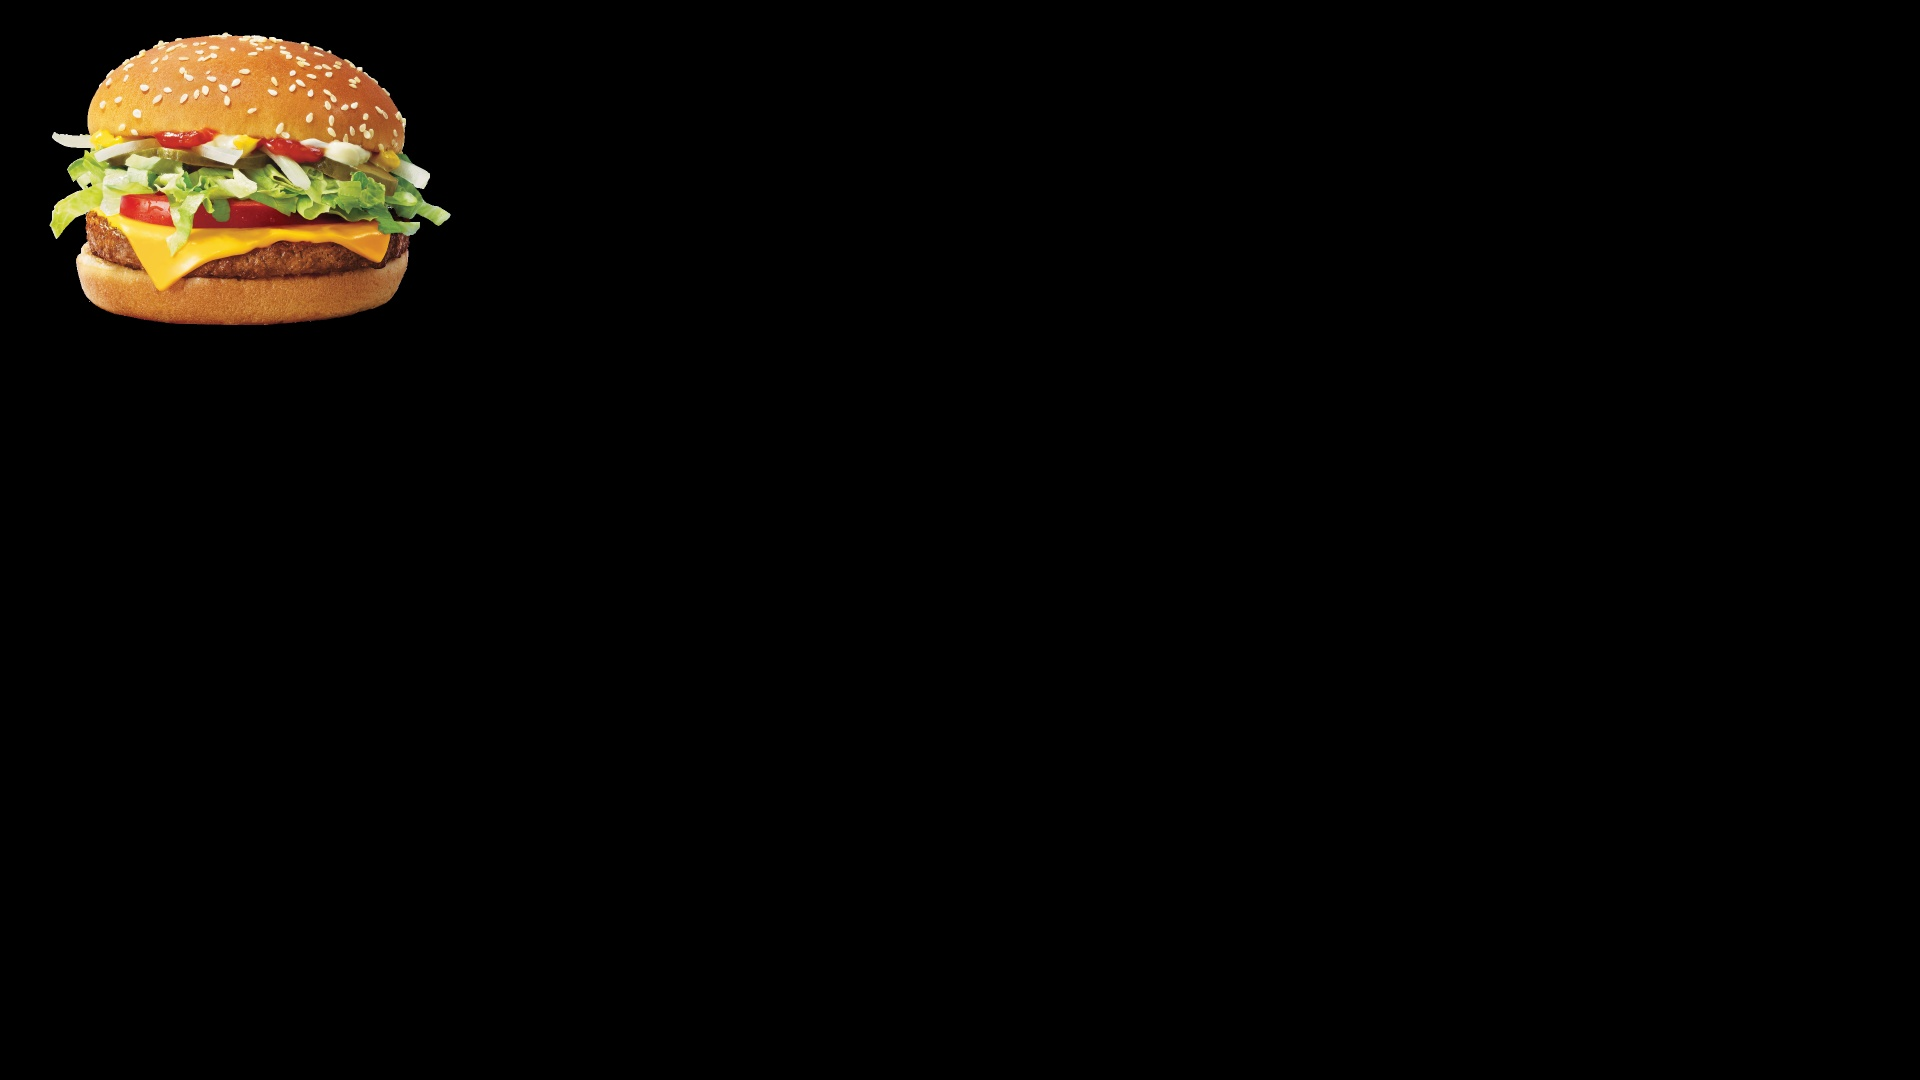


Displayed: Transformed image


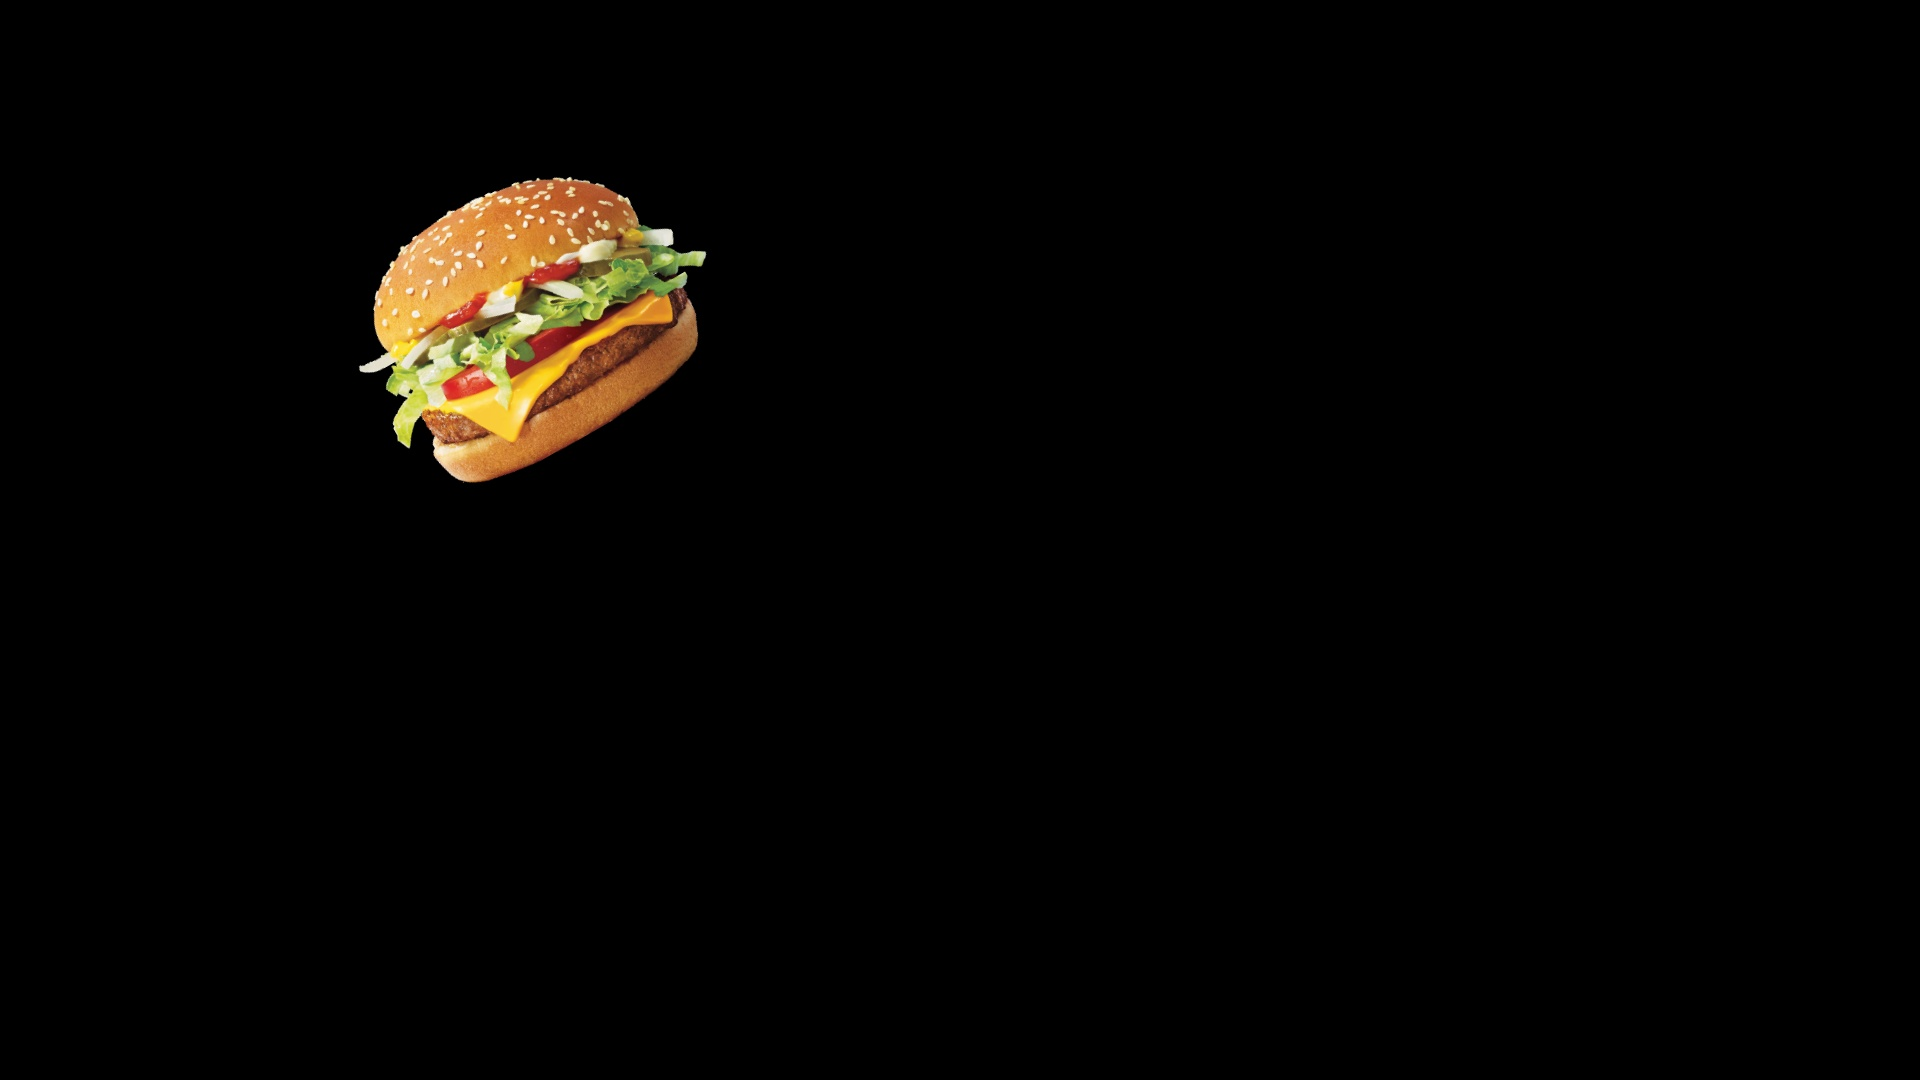

In [2]:
# 4. Transforms----------------------------------------------------------
'''
(1) Angle = 30 (positive degree-> counter-clockwise) 
(2) Scale = 0.9
(3) Translation with: 
X_new = X_old + 535 pixels = 240 + 535 = 775 
Y_new = Y_old + 335 pixels = 200 + 335 = 535
'''
class Q4():
    def Transforms(self, angle, scale, translation_x, translation_y):
        image = cv2.imread("/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q4_image/burger.png")

        # image center
        (hight, width) = image.shape[:2]
        print(f"The hight(row.shape) of image: {hight}\nThe width(col.shape) of image: {width}")

        # hamburger center
        center = (240, 200) # (x,y)
        
        '''
        [ a, b, c ] a, b, d, e：控制旋轉、縮放和剪切等線性變換
        [ d, e, f ] c：水平方向的平移分量, f：垂直方向的平移分量
        根據 center 和 angle，會自動計算 a, b, d, e 的值
        '''
        # cv2.getRotationMatrix2D() 建立一個 2x3 的仿射變換矩陣 M
        M = cv2.getRotationMatrix2D(center, angle, scale)
        '''
        center：影像的旋轉中心點。
        angle：旋轉角度，正值表示逆時針旋轉，負值表示順時針旋轉。
        scale：縮放比例。
        '''        
        # Translation
        M[0, 2] += translation_x - center[0]
        M[1, 2] += translation_y - center[1]
    
        # cv2.warpAffine(img, M, (width, hight)) 進行仿射變換後輸出 (width, hight)尺寸
        transformed_image = cv2.warpAffine(image, M, (width, hight))

        # display
        ret, buffer = cv2.imencode('.jpg', image)
        print("\nDisplayed: Origine")
        display(Image(data=buffer.tobytes()))
        
        ret, buffer = cv2.imencode('.jpg', transformed_image)
        print("\nDisplayed: Transformed image")
        display(Image(data=buffer.tobytes()))

q4 = Q4()
q4.Transforms(30, 0.9, 535, 335)


### **VGG19 (Visual Geometry Group 19-layer network)**  
- VGG19 是一種深度卷積神經網路（CNN），與 **VGG16** 類似，但擁有更深的網路結構。

**VGG19 網路結構：**

    - `Conv3-64` 代表 3×3 卷積，輸出通道數 64
    - `MaxPooling 2×2, stride=2` 用來降維
    -  最後 3 層為 FC

| 層數 | 類型 | 輸出大小 (ImageNet, 224×224 輸入) |
|------|------|--------------------------|
| 1-2  | Conv3-64, Conv3-64 | 224 × 224 × 64 |
| 3    | MaxPooling (2×2, stride=2) | 112 × 112 × 64 |
| 4-5  | Conv3-128, Conv3-128 | 112 × 112 × 128 |
| 6    | MaxPooling (2×2, stride=2) | 56 × 56 × 128 |
| 7-9  | Conv3-256, Conv3-256, Conv3-256, Conv3-256 | 56 × 56 × 256 |
| 10   | MaxPooling (2×2, stride=2) | 28 × 28 × 256 |
| 11-15 | Conv3-512, Conv3-512, Conv3-512, Conv3-512 | 28 × 28 × 512 |
| 16   | MaxPooling (2×2, stride=2) | 14 × 14 × 512 |
| 17-21 | Conv3-512, Conv3-512, Conv3-512, Conv3-512 | 14 × 14 × 512 |
| 22   | MaxPooling (2×2, stride=2) | 7 × 7 × 512 |
| 23   | FC 4096 | 1 × 1 × 4096 |
| 24   | FC 4096 | 1 × 1 × 4096 |
| 25   | FC 1000 (Softmax) | 1 × 1 × 1000 |

**VGG19 優點：**
- **較深的網路，提取更豐富的特徵**
- **小型卷積核（3×3）加深網路而不增加參數過多**
- **適用於影像分類、物件偵測、風格遷移（Style Transfer）等應用**

**VGG19 缺點：**
- **參數量大（≈143M parameters），計算成本高**
- **容易 overfitting**
- **沒有 BN，訓練較慢**



### **Batch Normalization (BN)**
- Batch Normalization 主要用來**加速訓練深度神經網路**，解決**內部協變偏移（Internal Covariate Shift）**。

- **內部協變偏移 (Internal Covariate Shift)**
    - 在深度網路中，每層的輸出分佈會隨著訓練過程改變，導致每一層輸出的分佈不穩定，影響學習效率。
    - BN 透過 **標準化輸入數據（Zero Mean/ mean=0, Unit Variance / std=1）**，讓不同 mini-batch 之間的分佈更穩定，加速收斂。

- **BN 的優點：**
    - **更快收斂**：平滑化輸出分佈，梯度下降更穩定
    - **減少內部協變偏移**：讓網路輸出的分佈更穩定
    - **降低對學習率的敏感度**可以用**較高的學習率**訓練，更快達到較好效果
    - **有輕微正則化效果**：時甚至可以減少 Dropout 的使用

- **BN 的缺點：**
    - **對 Small Batch 不友好**：BN 需要**足夠大的 batch size（通常 ≥ 32）** 來計算統計量，小 batch 會導致統計不穩定
    - **影響 Inference 效能**：在訓練時，BN 是對 **mini-batch** 進行標準化；但在 inference 時，使用的是**整個訓練集的統計量**，這可能導致分佈不匹配。

- **解決辦法：**
    - 使用 **Group Normalization (GN)** 來取代 BN
    - 針對推理時，使用**動態調整 momentum**來更新統計量

**比較 VGG19：**

| 模型 | BN | 參數量 | 訓練速度 | 過擬合 |
|------|----|--------|----------|--------|
| **VGG19** | ✖︎  | ≈143M | 慢 | 易 overfitting |
| **VGG19-BN** |  ✔︎  | ≈143M | 快 | 較穩定 |

- 要訓練 VGG19，**建議使用 BN**，會**更快、更穩定。**

### **CIFAR-10（Canadian Institute For Advanced Research-10 classes）**
- CIFAR-10 是一個 **小型圖像分類數據集**，主要用來 **訓練和測試影像分類模型**，包含 **60,000 張 32×32 彩色圖片**，分為 **10 個類別**，每個類別 **6,000 張圖片**，適合用來測試 **深度學習模型的影像分類能力**。

| 屬性 | 數值 |
|------|------|
| **圖片數量** | 60,000 張 |
| **圖片大小** | 32 × 32 像素 |
| **顏色模式** | RGB (3通道) |
| **類別數量** | 10 個 |
| **每類圖片數量** | 6,000 張 |
| **訓練集大小** | 50,000 張 |
| **測試集大小** | 10,000 張 |

- CIFAR-10 共有 **10 個物件類別**，分為**動物、交通工具**等：

| 類別編號 | 類別名稱 (英文) | 類別名稱 (中文) |
|----------|--------------|--------------|
| 0 | airplane | 飛機 |
| 1 | automobile | 汽車 |
| 2 | bird | 鳥 |
| 3 | cat | 貓 |
| 4 | deer | 鹿 |
| 5 | dog | 狗 |
| 6 | frog | 青蛙 |
| 7 | horse | 馬 |
| 8 | ship | 船 |
| 9 | truck | 卡車 |

- **適合作為 CNN（卷積神經網路）分類的基準測試**：CIFAR-10 是 **最常用的影像分類數據集之一**，可以用來測試 **VGG, ResNet, DenseNet** 等模型。

- **適合學習深度學習**：CIFAR-10 是**標準小型數據集**，適合初學者**練習影像分類模型**。

- **圖片小，計算成本低**：每張圖片只有**32×32**，訓練速度較快，適合**快速驗證模型效果**。

- **常見的 CNN 模型在 CIFAR-10 上的表現**

| 模型 | Top-1 準確率 |
|------|------------|
| AlexNet | ~80% |
| VGG19 | ~91% |
| ResNet-18 | ~93% |
| ResNet-50 | ~95% |
| DenseNet-121 | ~95% |


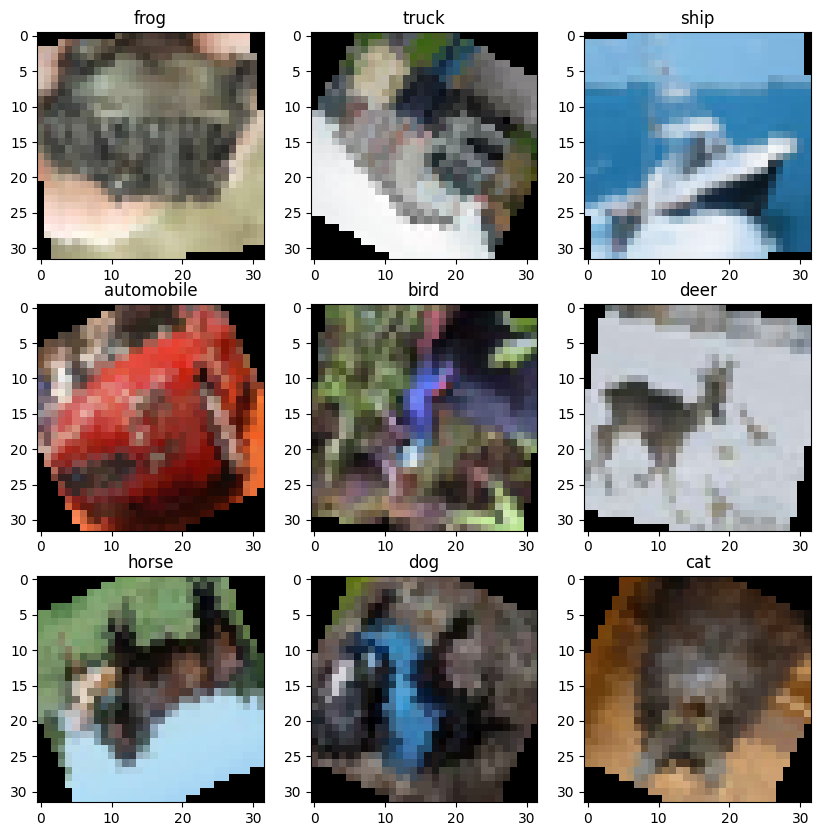

In [5]:
# 5.1 Show Augmented Images----------------------------------------------

class Q51():
    def Show_Augmented_Images(self):
        # get image path
        Q5_1 = "/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q5_image/Q5_1/"
        image_paths = []
        for image in os.listdir(Q5_1):
            image_paths.append(os.path.join(Q5_1,image))
 
        # transforms.Compose([...])可以自由搭配組合
        train_transform= transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.RandomVerticalFlip(),
                                              transforms.RandomRotation(30)])
        '''
        transforms.RandomHorizontalFlip()：50% 的機率水平翻轉影像
        transforms.RandomVerticalFlip()：50% 的機率垂直翻轉影像
        transforms.RandomRotation(30)：在 -30 到 30 度的範圍內隨機旋轉影像
        '''
        
        plt.figure(figsize=(10, 10)) # creat a new figure
        for i, image_path in enumerate(image_paths):
            ax = plt.subplot(3,3,i+1) # creat subfigure for each image
            '''
            3, 3 表示將圖形分割成 3x3 的網格
            i + 1 表示子圖在網格中的位置
            '''
            image = PILImage.open(image_path) # load image from file
            image = train_transform(image) # apply augmentatino
            
            ax.imshow(image) # show image on subfigure

            # os.path.basename(image_path) 提取檔案的名稱
            ax.set_title(os.path.basename(image_path).split(".")[0])
            
        plt.show()

q51 = Q51()
q51.Show_Augmented_Images()


In [3]:
# 5.2 Show Model Structure ----------------------------------------------

class Q52():
    def Show_Model_Structure(self):
        # creat the model
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
        model = torchvision.models.vgg19_bn(num_classes = 10)
        model = model.to(device)

        # torchsummary.summary() show model structure
        summary(model, (3,32,32)) # The size of image in Cifar10 is 32x32, and it has RGB channels.

q52 = Q52()
q52.Show_Model_Structure()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

### **小結論**

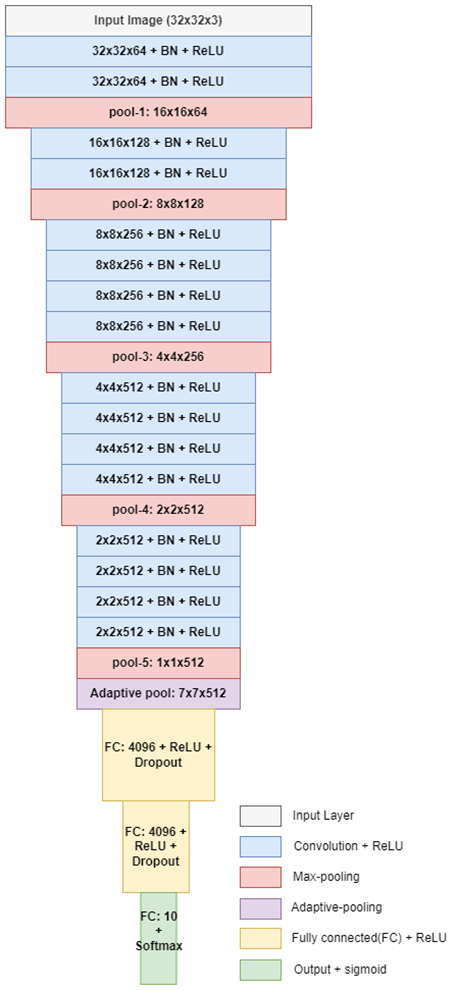

- (-1) 表示這個維度是可變的，具體值取決於訓練或推理時輸入的批次大小
- 用於 CIFAR-10 分類（32x32 輸入，10 類輸出）。
- **卷積層的參數量計算公式 = (輸入通道數 × 輸出通道數 × 卷積核高度 × 卷積核寬度) + 偏置項**
    - 輸入通道數（in_channels）：輸入圖像的通道數。
    - 輸出通道數（out_channels）：卷積層輸出的通道數。
    - 卷積核大小（kernel_size）：通常是 **(高度 × 寬度) 如 3x3**。
    - 偏置項（bias）：每個輸出通道通常有一個偏置參數，若啟用偏置，則為輸出通道數；若禁用，則為 0。

- 分析第一層(Conv2d-1)，輸入 [-1, 3, 32, 32]；輸出 [-1, 64, 32, 32]，空間維度未變（32x32），說明卷積層的步幅（stride）= 1；卷積核大小 3x3，即參數量為 (3 * 64 * 3 * 3) + 偏置參數(輸出通道數) 64 = 1792
    - 偏置參數的作用是為每個輸出通道提供一個獨立的偏移量，因此其**數量必須與輸出通道數一致**。在 Conv2d-1 中，輸出通道數是 64，所以偏置參數數量也是 64。

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1 ------Train Loss: 1.8356 | Train Acc: 31.19%
Epoch 1 --------Val Loss: 1.5155 |   Val Acc: 44.37%
Saved best model at epoch 1  | Val Acc：44.37%
Saved best model at epoch 2  | Val Acc：56.16%
Saved best model at epoch 3  | Val Acc：67.65%
Saved best model at epoch 4  | Val Acc：71.03%
Epoch 5 ------Train Loss: 0.8038 | Train Acc: 73.09%
Epoch 5 --------Val Loss: 0.7122 |   Val Acc: 75.85%
Saved best model at epoch 5  | Val Acc：75.85%
Saved best model at epoch 6  | Val Acc：77.91%
Saved best model at epoch 7  | Val Acc：77.95%
Saved best model at epoch 8  | Val Acc：79.62%
Saved best model at epoch 9  | Val Acc：81.62%
Epoch 10------Train Loss: 0.4983 | Train Acc: 83.59%
Epoch 10--------Val Loss: 0.5353 |   Val Acc: 81.91%
Saved best model at epoch 10 | Val Acc：81.91%
Saved best model at epoch 11 | Val Acc：83.88%
Epoch 15------Train Loss: 0.3610 | Train Acc: 88.00%
Epoch 15--------Val Loss: 0.4583 |   Val Acc: 84.81%
Saved best model at epoch 15 | Val Acc：84.81%
Saved best model at epoc

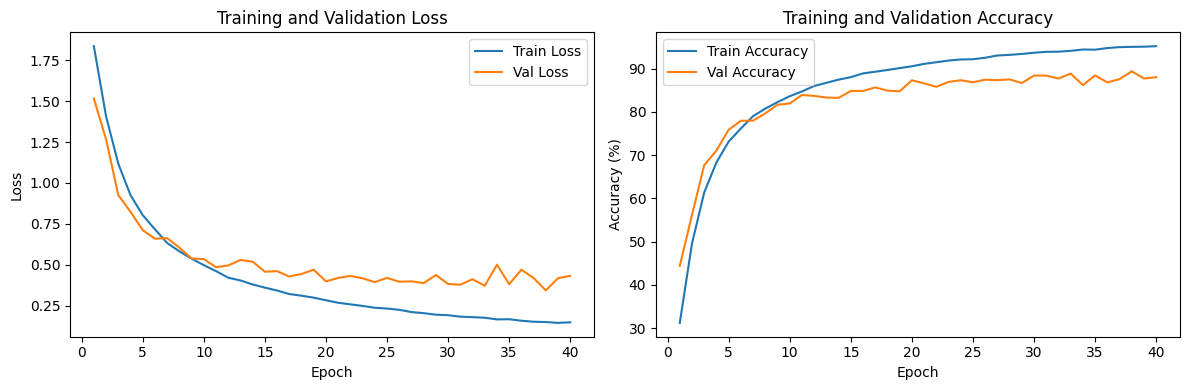

['.virtual_documents', 'vgg19_bn_training_curves.png', 'best_vgg19_bn.pth']


In [4]:
# 5.3_1 Show Acc and Loss with lr = 0.01-------------------------------------------------

class Q53_1():
    def Show_Acc_and_Loss(self, batch_size, epochs, lr):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 1. Data Preprocessing
        
        # Data augmentation for training set
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 經統計後 CIFAR-10 的標準化 mean 和 std
        ])  # Normalize(r,g,b)
        
        # Data augmentation only normalize for val set
        val_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        
        '''
        transforms.RandomCrop(32, padding=4)
            1. 先在影像的四周 padding 4 pixel 的邊框，將影像擴展為 3x40x40
            2. 從擴展後的 3x40x40 影像中隨機裁剪出一個 3x32x32 的區域
            3. 回傳裁切後的 3*32*32 圖片給下一段程式

        transforms.ToTensor() 
            1. 將影像的像素值，從 0 到 255 的範圍縮放到 0 到 1 的範圍
            2. 輸出一個形狀為 (batch_size, channels, height, width) 的 tensor
            
        transforms.Normaliz() 有助於加速模型訓練，提高模型的收斂速度和準確性，這些數值通常是基於訓練資料集的統計特性計算得出的
            1. (0.4914, 0.4822, 0.4465)是影像 RGB 的 mean，用於中心化像素值
            2. (0.2023, 0.1994, 0.2010) 是影像 RGB 的 std，用於縮放像素值
        '''

        # load CIFAR-10 dataset on kaggle -> torchvision.datasets.CIFAR10() 解析 data_root 的 cifar-10-python.tar.gz 文件
        data_root = '/kaggle/input/cifar10-python'
        train_dataset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=train_transform)
        val_dataset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=False, transform=val_transform)

        # 用自己上傳的 dataset set DataLoader
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=2
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=2
        )
        '''
        DataLoader：
            1. 當資料集總樣本數無法被批次大小整除時，會產生剩餘樣本，DataLoader 預設為捨棄
            2. 標籤資料由 DataLoader 負責轉換為 PyTorch tensor；影像資料則是由 transforms.ToTensor() 轉換
                - DataLoader 會將標籤資料轉換為 PyTorch tensor，以便與影像資料一起傳遞給模型
            3. num_workers 為一個超參數，用於設定資料載入的子程序數量，可以顯著加速資料載入的速度
                - 子程序負責從資料集中讀取資料，並將資料傳遞給主程序（main process）
                - 主程序負責將資料傳遞給模型進行訓練
        '''
        # 2. load VGG19 model with BatchNorm
        model = vgg19_bn(pretrained=False, num_classes=10)
        model = model.to(device)
        
        # 3. define Loss function and optimizer
        criterion = nn.CrossEntropyLoss() # nn.CrossEntropyLoss() = nn.LogSoftmax() + nn.NLLLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) # weight_decay 就是 L2
        
        # record training、val loss and acc
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = 0.0  # for best val acc model
        
        # 4. define train and val 
        def train(epoch):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                '''
                每個 train_loader 中輸出一個 tuple：
                    1. images(inputs)：一個 shape 為 (batch_size, channels, height, width) 的 tensor
                    2. labels：一個 shape 為 (batch_size) 的 tensor，因為每一筆影像配對一個 label，有幾筆 image = 有幾筆 label
                '''

                # .zero_grad() 將模型所有參數的梯度清零。
                # 是必要的，因為 PyTorch 的梯度會累加，如果不清零，前一批次的梯度會影響當前批次。
                optimizer.zero_grad() 

                # Forward Propagation： inputs (batch_size, channels, height, width) -> outputs (batch_size, num_classes)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward Propagation
                loss.backward() # 梯度會儲存在模型參數的 .grad 屬性中，為後續優化步驟做準備
                optimizer.step()
                '''
                optimizer.step()
                    1. 根據計算出的梯度，使用 Optimizer 更新模型參數
                    2. 對於 SGD，更新規則是：param = param − lr × grad
                '''
                running_loss += loss.item() # 累積整個 epoch 的 loss
                _, predicted = torch.max(outputs, 1)
                '''
                torch.max() 會回傳兩個 tensor：
                    1. 第一個 tensor 包含每個樣本的最大「值」
                    2. 第二個 tensor 包含每個樣本最大值的「索引」，也就是預測的「類別」
                    
                舉例：
                outputs = torch.tensor([[0.1, 0.9, 0.2], 表示 batch_size = 3, num_classes = 3
                                        [0.8, 0.1, 0.3],
                                        [0.2, 0.3, 0.5]])

                _, predicted = torch.max(outputs, 1) 會輸出 [1, 0, 2]，shape 由 batch_size 決定 
                '''
                total += labels.size(0) # .size = .shape 回傳 batch_size；total 代表實際有經過 train 的 sample數
                correct += (predicted == labels).sum().item() # .item() 用於從單一元素的 tensor 中取得 Python 數值，多元素會 error

            # calculate acc
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100. * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
        
        def validate(epoch):
            model.eval()
            '''
            model.train() 訓練模式時，某些層（如 BatchNorm 和 Dropout）會啟用特定行為：
                - BatchNorm 會更新 mean 和 std 的運行統計。
                - Dropout 會隨機丟棄部分神經元以防止 overfitting。

            model.eval()  評估模式時，確保驗證過程一致，不受隨機性影響
                - BatchNorm 層使用訓練時記錄的運行 mean 和 std，而不是當前批次的統計值。
                - Dropout 層被禁用（即不隨機丟棄神經元）。
            '''
            running_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad(): # 關閉梯度計算，驗證階段不需要更新模型參數，同時能減少 memory 使用並加速計算
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Forward Propagation： inputs (batch_size, channels, height, width) -> outputs (batch_size, num_classes)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels) # 注意：這裡計算 loss 僅用於評估，不會用於反向傳播
                    
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(val_loader)
            epoch_acc = 100. * correct / total
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
                
            # save the bset model
            nonlocal best_val_acc # 使用 global，允許函數「修改」外部定義的 best_val_acc
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), 'best_vgg19_bn.pth')
                '''
                torch.save()：保存 model 的參數（state_dict）到 best_vgg19_bn.pth
                state_dict 是一個字典，包含模型的所有參數（weights、bias）
                '''
                print(f"Saved best model at epoch {epoch+1:<2} | Val Acc：{best_val_acc:.2f}%")
        
        # 5. trainng
        for epoch in range(epochs):
            train(epoch)
            validate(epoch)
        
        # 6. display loss / acc curve
        plt.figure(figsize=(12, 4))
        
        # loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        # acc
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        
        # save
        plt.tight_layout()
        plt.savefig('vgg19_bn_training_curves.png')
        plt.show()

q53_1 = Q53_1()
q53_1.Show_Acc_and_Loss(128, 40, 0.01)
print(os.listdir("/kaggle/working/"))


Epoch 1 ------Train Loss: 1.8732 | Train Acc: 29.07%
Epoch 1 --------Val Loss: 1.5171 |   Val Acc: 42.44%
Saved best model at epoch 1  | Val Acc：42.44%
Saved best model at epoch 2  | Val Acc：53.52%
Saved best model at epoch 3  | Val Acc：58.05%
Saved best model at epoch 4  | Val Acc：62.19%
Epoch 5 ------Train Loss: 1.0453 | Train Acc: 62.16%
Epoch 5 --------Val Loss: 0.9853 |   Val Acc: 64.95%
Saved best model at epoch 5  | Val Acc：64.95%
Saved best model at epoch 6  | Val Acc：67.44%
Saved best model at epoch 7  | Val Acc：69.21%
Saved best model at epoch 8  | Val Acc：71.70%
Saved best model at epoch 9  | Val Acc：73.12%
Epoch 10------Train Loss: 0.7545 | Train Acc: 73.40%
Epoch 10--------Val Loss: 0.7534 |   Val Acc: 73.94%
Saved best model at epoch 10 | Val Acc：73.94%
Saved best model at epoch 11 | Val Acc：75.45%
Saved best model at epoch 12 | Val Acc：76.54%
Saved best model at epoch 13 | Val Acc：76.81%
Saved best model at epoch 14 | Val Acc：77.83%
Epoch 15------Train Loss: 0.5930 | Tra

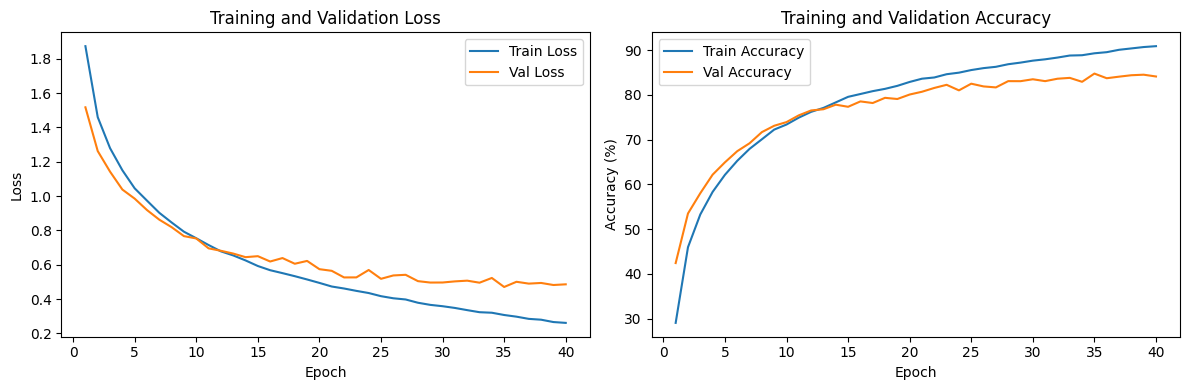

['.virtual_documents', 'best_vgg19_bn.pth', 'vgg19_bn_training_curves.png']


In [11]:
# 5.3_2 Show Acc and Loss with lr = 0.001-------------------------------------------------

class Q53_2():
    def Show_Acc_and_Loss(self, batch_size, epochs, lr):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 1. Data Preprocessing
        
        # Data augmentation for training set
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, padding=4),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 經統計後 CIFAR-10 的標準化 mean 和 std
        ])  # Normalize(r,g,b)
        
        # Data augmentation only normalize for val set
        val_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
        
        '''
        transforms.RandomCrop(32, padding=4)
            1. 先在影像的四周 padding 4 pixel 的邊框，將影像擴展為 3x40x40
            2. 從擴展後的 3x40x40 影像中隨機裁剪出一個 3x32x32 的區域
            3. 回傳裁切後的 3*32*32 圖片給下一段程式

        transforms.ToTensor() 
            1. 將影像的像素值，從 0 到 255 的範圍縮放到 0 到 1 的範圍
            2. 輸出一個形狀為 (batch_size, channels, height, width) 的 tensor
            
        transforms.Normaliz() 有助於加速模型訓練，提高模型的收斂速度和準確性，這些數值通常是基於訓練資料集的統計特性計算得出的
            1. (0.4914, 0.4822, 0.4465)是影像 RGB 的 mean，用於中心化像素值
            2. (0.2023, 0.1994, 0.2010) 是影像 RGB 的 std，用於縮放像素值
        '''

        # load CIFAR-10 dataset on kaggle -> torchvision.datasets.CIFAR10() 解析 data_root 的 cifar-10-python.tar.gz 文件
        data_root = '/kaggle/input/cifar10-python'
        train_dataset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=False, transform=train_transform)
        val_dataset = torchvision.datasets.CIFAR10(root=data_root, train=False, download=False, transform=val_transform)

        # 用自己上傳的 dataset set DataLoader
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=2
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=False, 
            num_workers=2
        )
        '''
        DataLoader：
            1. 當資料集總樣本數無法被批次大小整除時，會產生剩餘樣本，DataLoader 預設為捨棄
            2. 標籤資料由 DataLoader 負責轉換為 PyTorch tensor；影像資料則是由 transforms.ToTensor() 轉換
                - DataLoader 會將標籤資料轉換為 PyTorch tensor，以便與影像資料一起傳遞給模型
            3. num_workers 為一個超參數，用於設定資料載入的子程序數量，可以顯著加速資料載入的速度
                - 子程序負責從資料集中讀取資料，並將資料傳遞給主程序（main process）
                - 主程序負責將資料傳遞給模型進行訓練
        '''
        # 2. load VGG19 model with BatchNorm
        model = vgg19_bn(pretrained=False, num_classes=10)
        model = model.to(device)
        
        # 3. define Loss function and optimizer
        criterion = nn.CrossEntropyLoss() # nn.CrossEntropyLoss() = nn.LogSoftmax() + nn.NLLLoss()
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) # weight_decay 就是 L2
        
        # record training、val loss and acc
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_val_acc = 0.0  # for best val acc model
        
        # 4. define train and val 
        def train(epoch):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                '''
                每個 train_loader 中輸出一個 tuple：
                    1. images(inputs)：一個 shape 為 (batch_size, channels, height, width) 的 tensor
                    2. labels：一個 shape 為 (batch_size) 的 tensor，因為每一筆影像配對一個 label，有幾筆 image = 有幾筆 label
                '''

                # .zero_grad() 將模型所有參數的梯度清零。
                # 是必要的，因為 PyTorch 的梯度會累加，如果不清零，前一批次的梯度會影響當前批次。
                optimizer.zero_grad() 

                # Forward Propagation： inputs (batch_size, channels, height, width) -> outputs (batch_size, num_classes)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward Propagation
                loss.backward() # 梯度會儲存在模型參數的 .grad 屬性中，為後續優化步驟做準備
                optimizer.step()
                '''
                optimizer.step()
                    1. 根據計算出的梯度，使用 Optimizer 更新模型參數
                    2. 對於 SGD，更新規則是：param = param − lr × grad
                '''
                running_loss += loss.item() # 累積整個 epoch 的 loss
                _, predicted = torch.max(outputs, 1)
                '''
                torch.max() 會回傳兩個 tensor：
                    1. 第一個 tensor 包含每個樣本的最大「值」
                    2. 第二個 tensor 包含每個樣本最大值的「索引」，也就是預測的「類別」
                    
                舉例：
                outputs = torch.tensor([[0.1, 0.9, 0.2], 表示 batch_size = 3, num_classes = 3
                                        [0.8, 0.1, 0.3],
                                        [0.2, 0.3, 0.5]])

                _, predicted = torch.max(outputs, 1) 會輸出 [1, 0, 2]，shape 由 batch_size 決定 
                '''
                total += labels.size(0) # .size = .shape 回傳 batch_size；total 代表實際有經過 train 的 sample數
                correct += (predicted == labels).sum().item() # .item() 用於從單一元素的 tensor 中取得 Python 數值，多元素會 error

            # calculate acc
            epoch_loss = running_loss / len(train_loader)
            epoch_acc = 100. * correct / total
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}------Train Loss: {epoch_loss:<.4f} | Train Acc: {epoch_acc:<.2f}%")
        
        def validate(epoch):
            model.eval()
            '''
            model.train() 訓練模式時，某些層（如 BatchNorm 和 Dropout）會啟用特定行為：
                - BatchNorm 會更新 mean 和 std 的運行統計。
                - Dropout 會隨機丟棄部分神經元以防止 overfitting。

            model.eval()  評估模式時，確保驗證過程一致，不受隨機性影響
                - BatchNorm 層使用訓練時記錄的運行 mean 和 std，而不是當前批次的統計值。
                - Dropout 層被禁用（即不隨機丟棄神經元）。
            '''
            running_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad(): # 關閉梯度計算，驗證階段不需要更新模型參數，同時能減少 memory 使用並加速計算
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Forward Propagation： inputs (batch_size, channels, height, width) -> outputs (batch_size, num_classes)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels) # 注意：這裡計算 loss 僅用於評估，不會用於反向傳播
                    
                    running_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            epoch_loss = running_loss / len(val_loader)
            epoch_acc = 100. * correct / total
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
            elif (epoch+1) % 5 == 0:
                print(f"Epoch {epoch+1:<2}--------Val Loss: {epoch_loss:<.4f} |   Val Acc: {epoch_acc:<.2f}%")
                
            # save the bset model
            nonlocal best_val_acc # 使用 global，允許函數「修改」外部定義的 best_val_acc
            if epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                torch.save(model.state_dict(), 'best_vgg19_bn.pth')
                '''
                torch.save()：保存 model 的參數（state_dict）到 best_vgg19_bn.pth
                state_dict 是一個字典，包含模型的所有參數（weights、bias）
                '''
                print(f"Saved best model at epoch {epoch+1:<2} | Val Acc：{best_val_acc:.2f}%")
        
        # 5. trainng
        for epoch in range(epochs):
            train(epoch)
            validate(epoch)
        
        # 6. display loss / acc curve
        plt.figure(figsize=(12, 4))
        
        # loss
        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        # acc
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        
        # save
        plt.tight_layout()
        plt.savefig('vgg19_bn_training_curves.png')
        plt.show()

q53_2 = Q53_2()
q53_2.Show_Acc_and_Loss(128, 40, 0.001)
print(os.listdir("/kaggle/working/"))


## **隨機梯度下降（SGD, Stochastic Gradient Descent）**

- 梯度下降演算法的關鍵差異在於**每次更新時使用的資料量**：
- 
| **方法** | **每次參與計算的樣本數** | **計算成本** | **收斂速度** | **更新頻率** | **適用場景** |
|-----------|----------------|--------------|------------|--------------|--------------|
| **Batch Gradient Descent（批量梯度下降）** | **全部訓練數據** | 高（因為要計算所有樣本的平均梯度） | 穩定但慢 | 1 次更新 / epoch | 小規模數據集，計算資源充足 |
| **Mini-Batch Gradient Descent（小批量梯度下降）** | **一小部分樣本（例如 32、64、128）** | 適中 | 介於 SGD 和 Batch 之間 | 每個 mini-batch 更新一次 | **深度學習最常用的方法**，兼具計算效率與收斂穩定性 |
| **Stochastic Gradient Descent（SGD, 隨機梯度下降）** | **1 個樣本** | 最低 | 震盪較大，但有時能更快找到較佳解 | **每個樣本更新一次** | 適用於大規模數據集，但收斂不穩定 |

    1. **每次更新只使用「一個」訓練樣本**
        - 標準梯度下降（Batch Gradient Descent）需要計算所有訓練樣本的梯度，**深度學習中幾乎不用，因為太慢且計算資源需求太高**
        - **SGD 每次只從訓練集隨機選擇一個樣本來計算梯度**，**大幅減少計算量**，訓練速度更快

    2. **更新頻繁，可能較不穩定**
        - 每次僅用一個樣本的梯度來更新權重，更新過程**波動大、容易震盪**，因此這也是為什麼 SGD + Momentum 常被用來訓練 CNN

    3. **適合大規模數據集**
        - 在大型數據集（如 **CIFAR-10、ImageNet**）上，SGD 比 Batch Gradient Descent **更快、更省記憶體**

    4. Mini-batch Gradient Descent：介於 SGD 和 Batch GD 之間，通常使用 **32~256** 張圖來計算梯度，能兼顧穩定性與速度。

- **其他變形的 SGD Optimizers**，SGD 可能收斂較慢，因此許多改進版被提出：

| Optimizer | 適用情境 | 優點 | 缺點 |
|-----------|--------|------|------|
| **SGD** | 標準梯度下降 | 計算量低、適合大數據 | 震盪大、收斂慢 |
| **SGD + Momentum** | 深度 CNN (ResNet, VGG) | 收斂穩定 | 需調整 momentum |
| **SGD + Nesterov** | 進階 CNN | 比 Momentum 更快收斂 | 計算稍微增加 |
| **Adam** | 小型數據集 | **學習率自適應，收斂快** | **容易 overfitting** |
| **AdamW** | 深層神經網路 | 改善 Adam 的 weight decay 問題 | 計算稍重 |
| **RMSprop** | RNN / LSTM | 適合非平穩數據 | 需調整參數 |
| **Adagrad** | 會調整每個參數的學習率 | **適合稀疏數據** |

### **超參數調整策略**
| **超參數** | **增大影響** | **減小影響** | **調整建議** |
|------------|-------------|-------------|--------------|
| **Batch Size** | 訓練更穩定、計算更快、可能 overfitting | 訓練更噪聲、泛化能力更強 | **64~256** 為較常見範圍 |
| **Epochs** | 訓練更完整、可能 overfitting | 訓練不足、模型不夠準確 | 監控 loss，適時 **early stopping** |
| **Learning Rate** | 訓練更快、可能發散 | 訓練更穩定、可能過慢 | 使用 **lr decay** 動態調整 |


<ipython-input-9-e3f6a7bcf6d3>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


Predicted Class: cat


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


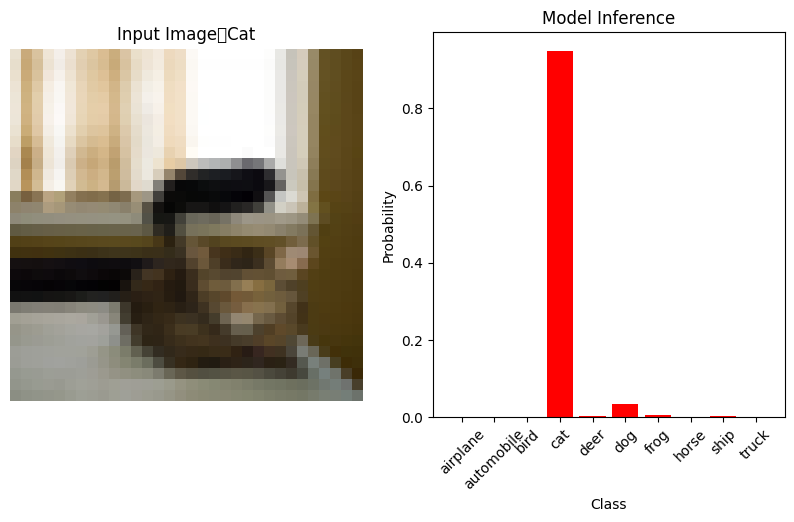

In [9]:
# 5.4 Run Inference-------------------------------------------------

class Q54():
    def Run_Inference(self):
        
        model_path = "/kaggle/working/best_vgg19_bn.pth"
        model = models.vgg19_bn(pretrained=False)  # initialize

        # classifier[6] 是 VGG19 的最後一層，用於分類 1000 個類別（for ImageNet dataset）
        model.classifier[6] = torch.nn.Linear(4096, 10)  # 修改 for CIFAR-10 classes
        
        # state_dict 為 model weights and bias
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) 
        model.eval()
        
        transform = transforms.Compose([
            transforms.Resize((32, 32)),  # for CIFAR-10 size 
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]) # 如果不做 Normalize，輸入的數據分佈與模型訓練時的不同，會導致輸出錯誤
        
        image_path = "/kaggle/input/dataset-opencvdl-hw1/Dataset_OpenCvDl_Hw1/Q5_image/Q5_4/cat.png"
        image = PILImage.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0)  # 最前面增加一個維度 for batch_size 符合輸入要求

        # 順序是安排過的，預測的類別索引 argmax 值會直接對應到這些類別名稱
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck']
        
        # inference
        with torch.no_grad():
            
            # forward
            output = model(image_tensor)

            # training 時，CrossEntropyLoss 內部自動應用 softmax 了，這邊要手動操作取得機率值
            probabilities = F.softmax(output[0], dim=0)
            
            # .argmax() 用來返回概率分佈中最大值的 index
            predicted_class = torch.argmax(probabilities).item()  # 取得預測類別索引
        
        # display
        plt.figure(figsize=(10, 5))


        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title("Input Image：Cat")

        print(f"Predicted Class: {class_names[predicted_class]}")
        plt.subplot(1, 2, 2)
        plt.bar(class_names, probabilities.numpy(), color="red")
        plt.xlabel("Class")
        plt.ylabel("Probability")
        plt.title("Model Inference")
        plt.xticks(rotation=45)
        plt.show()

q54 = Q54()
q54.Run_Inference()
